In [153]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [209]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd
from bisect import *
from decimal import Decimal

In [155]:
layerStart = [0,96,320,672,1184,1296,1408,1520,1632,1744,1856]
layerName = ["BL1","BL2","BL3","BL4","E+1", "E+2", "E+3","E-1", "E-2", "E-3"]
def layer(x) :
    return bisect_right(layerStart, x)

print layer(0),layer(1),layer(95),layer(96),layer(97),layer(1743),layer(1744),layer(1855)

i2p = math.pi/32769.0

1 1 1 2 2 9 10 10


In [156]:
def curvature(h, ptmin, region_origin_radius,hardPtCut, first, rad=False) :
    region_origin_x = 0
    region_origin_y = 0
    x1 = h['r1']*np.cos(h['phi1']) if first else h['r2']*np.cos(h['phi2'])
    y1 = h['r1']*np.sin(h['phi1']) if first else h['r2']*np.sin(h['phi2'])
    x2 = h['r2']*np.cos(h['phi2']) if first else h['r3']*np.cos(h['phi3'])
    y2 = h['r2']*np.sin(h['phi2']) if first else h['r3']*np.sin(h['phi3'])
    x3 = h['r3']*np.cos(h['phi3']) if first else h['r4']*np.cos(h['phi4'])
    y3 = h['r3']*np.sin(h['phi3']) if first else h['r4']*np.sin(h['phi4'])
    
    distance_13_squared = (x1 - x3)*(x1 - x3) + (y1 - y3)*(y1 - y3)
    tan_12_13_half_mul_distance_13_squared = abs(y1 * (x2 - x3) + y2 * (x3 - x1) + y3 * (x1 - x2))
    # high pt : just straight
    straight = tan_12_13_half_mul_distance_13_squared * ptmin <= 1.0e-4*distance_13_squared
    def ifStraight() :
        distance_3_beamspot_squared = (x3-region_origin_x) * (x3-region_origin_x) + (y3-region_origin_y) * (y3-region_origin_y)
        dot_bs3_13 = ((x1 - x3)*( region_origin_x - x3) + (y1 - y3) * (region_origin_y-y3))
        proj_bs3_on_13_squared = dot_bs3_13*dot_bs3_13/distance_13_squared
        distance_13_beamspot_squared  = distance_3_beamspot_squared -  proj_bs3_on_13_squared
        return distance_13_beamspot_squared < (region_origin_radius+phiCut)*(region_origin_radius+phiCut)
    
    def standard() :
        # 87 cm/GeV = 1/(3.8T * 0.3)
        # 165 cm/GeV = 1/(2T * 0.3)
    
        # take less than radius given by the hardPtCut and reject everything below
        minRadius = hardPtCut*87 #  // FIXME move out and use real MagField
    
        det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)
    
        offset = x2 * x2 + y2*y2
    
        bc = (x1 * x1 + y1 * y1 - offset)*0.5
    
        cd = (offset - x3 * x3 - y3 * y3)*0.5
    
    
    
        idet = 1./ det;
    
        x_center = (bc * (y2 - y3) - cd * (y1 - y2)) * idet
        y_center = (cd * (x1 - x2) - bc * (x2 - x3)) * idet
    
        radius = np.sqrt((x2 - x_center)*(x2 - x_center) + (y2 - y_center)*(y2 - y_center))
        if rad: return radius
        def domore() :
            centers_distance_squared = (x_center - region_origin_x)*(x_center - region_origin_x) + (y_center - region_origin_y)*(y_center - region_origin_y)
            #minimumOfIntersectionRange = (radius - region_origin_radius_plus_tolerance)*(radius - region_origin_radius_plus_tolerance)
            #ok = centers_distance_squared >= minimumOfIntersectionRange
            return np.sqrt(centers_distance_squared)-radius # - region_origin_radius


        # return domore().where(radius > minRadius, radius <= minRadius)
        return domore()
    
    #return ifStraight().where(straight,standard())
    return standard()

In [157]:
def dca(h, first, curv=False):
    
   x1 = h['r1']*np.cos(h['phi1']) if first else h['r2']*np.cos(h['phi2'])
   y1 = h['r1']*np.sin(h['phi1']) if first else h['r2']*np.sin(h['phi2'])
   x2 = h['r2']*np.cos(h['phi2']) if first else h['r3']*np.cos(h['phi3'])
   y2 = h['r2']*np.sin(h['phi2']) if first else h['r3']*np.sin(h['phi3'])
   x3 = h['r3']*np.cos(h['phi3']) if first else h['r4']*np.cos(h['phi4'])
   y3 = h['r3']*np.sin(h['phi3']) if first else h['r4']*np.sin(h['phi4'])
 
    
   noflip = abs(x3-x1) < abs(y3-y1)
   x1p = np.where(noflip, x1-x2, y1-y2)
   y1p = np.where(noflip, y1-y2, x1-x2)
   d12 = x1p*x1p + y1p*y1p
   x3p = np.where(noflip, x3-x2, y3-y2)
   y3p = np.where(noflip, y3-y2, x3-x2)
   d32 = x3p*x3p + y3p*y3p
   num = x1p*y3p-y1p*x3p  # num also gives correct sign for CT
   det = d12*y3p-d32*y1p

   st2 = d12*x3p-d32*x1p
   seq = det*det +st2*st2
   al2 = 1./np.sqrt(seq)
   be2 = -st2*al2
   ct = 2.*num*al2
   al2 *=det
   m_xp = x2
   m_yp = y2
   m_c = np.where(noflip, ct, -ct)
   m_alpha = np.where(noflip, al2, -be2)
   m_beta  = np.where(noflip, be2, -al2)

   if curv : return m_c
    
   x =  m_c*m_xp + m_alpha
   y =  m_c*m_yp + m_beta
   return (np.sqrt(x*x+y*y) - 1.)/m_c
    

In [158]:
def deltaphi(a,b,ch) :
    ch *=ch
    cb = ch*b
    ca = ch*a
    return np.arcsin(cb) - np.arcsin(ca)


def deltaphiA(a,b,ch) :
    ch *=ch
    d = b-a
    cd = ch*d
    ca = ch*a
    return cd*(1.+0.5*ca*(ca+cd)+cd*cd*0.1667)


def eta(r,z) :
    t = z/r
    return np.arcsinh(t);

def sag(r,c) :
    return 0.5*c*r*r

def phicutOld(a,b,c) :
    o = np.maximum(a,b)
    i = np.minimum(a,b)
    d = np.minimum(i,o-i)
    m = sag(o,c)
    return d*m/(0.5*o*i)

def phicut(a,b,c) :
   ro = np.maximum(a,b)
   ri = np.minimum(a,b)
   dr = ro-ri
   return dr/np.sqrt(4./(c*c) -ri*ro);

def zAtR(h,r) :
    zi = h['z1']
    zo = h['z3']
    ri = h['r1']
    ro = h['r3']
    return zi + (r-ri)*(zo-zi)/(ro-ri)


In [159]:
def alignRZ(h, rp, ptmin, first) :
    '''
    float radius_diff = std::abs(r1 - ro);
    float distance_13_squared = radius_diff*radius_diff + (z1 - zo)*(z1 - zo);
    
    float pMin = ptmin*std::sqrt(distance_13_squared); //this needs to be divided by radius_diff later
    
    float tan_12_13_half_mul_distance_13_squared = fabs(z1 * (getInnerR() - ro) + getInnerZ() * (ro - r1) + zo * (r1 - getInnerR())) ;
    return tan_12_13_half_mul_distance_13_squared * pMin <= thetaCut * distance_13_squared * radius_diff;
    '''
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
    fact = 1. if (rp=='r') else 10.
    radius_diff = fact*abs(ri - ro)
    distance_13_squared = radius_diff*radius_diff + (zi - zo)*(zi - zo)
    
    pMin = ptmin*np.sqrt(distance_13_squared) #this needs to be divided by radius_diff later
    
    tan_12_13_half_mul_distance_13_squared = fact*abs(zi * (rm - ro) + zm * (ro - ri) + zo * (ri - rm)) 
    return tan_12_13_half_mul_distance_13_squared * pMin/(distance_13_squared * radius_diff)

In [160]:
def alignRPZ(h, rp, first) :
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
     
    return (rm-ri)*(zo-zm) - (ro-rm)*(zm-zi)

In [161]:
def doublets(hits,l1,l2,cut=0.2) :
    nd=0
    for h1 in l1.itertuples() :
        phi = h1.phi
        hh = l2['phi'].searchsorted([phi-cut,phi+cut])
        hits.loc[h1.Index,'up0'] = hh[0]
        hits.loc[h1.Index,'up1'] = hh[1]
        nd += hh[1]-hh[0]
    return nd

In [162]:
def ml(pt1,pz1,pt2,pz2) :
    dp = pt1*pt2+pz1*pz2
    m1 = pt1*pt1+pz1*pz1
    m2 = pt2*pt2+pz2*pz2
    corr =  pt1/np.sqrt(m1)
    dp /=np.sqrt(m1*m2)
    dt = np.arccos(dp[dp<1]) 
    dtn = dt*np.sqrt(m1)*corr
    return dt,dtn

In [163]:
file = '/Users/innocent/data/ttbarIdealPU50HitsC.csv'
# file = '/Users/innocent/data/ttbarPU50Hits.csv'
# file = '/Users/innocent/data/ttbarPU0Hits.csv'
rawHits = pd.read_csv(file, delimiter=" ")
print '#rawhits', len(rawHits)

#rawhits 13982672


In [193]:
rawHits['phi'] =  np.arctan2(rawHits['yg'],rawHits['xg']) # rawHits['iphi']*i2p
rawHits['eta'] =  eta(rawHits['rg'],rawHits['zg'])
rawHits['seq'] = rawHits['det'].apply(layer)
rawHits['trackID'] = rawHits['tkId']+10000000*rawHits['ev']
rawHits['norm'] = 1./1000.
rawHits.sort_values(by=['ev','tkId','det'],inplace=True)
hits =  rawHits[rawHits['pt']>400]
print '#hits', len(hits)
print hits.head()
print hits.tail()

#hits 5833191
      ev   ind  det  charge        xg         yg         zg         rg   iphi  \
1014   1   406   19   45617  0.327468   3.295420  -4.949985   3.311650  15350   
2373   1  2245  146   32991  0.701991   7.170877  -9.392261   7.205155  15365   
1805   1  3789  401   35961  1.082605  11.257833 -14.069117  11.309768  15383   
7400   1  5096  793   71921  1.532926  16.360044 -19.902737  16.431705  15409   
1015   1   407   19   39949  0.265110   3.311063  -4.962011   3.321660  15550   

      xsize  ...       pt  n1  tkId2  pt2  n2       phi       eta  seq  \
1014     13  ...    12402   3      0    0   0  1.471751 -1.191830    1   
2373     20  ...    12402   4      0    0   0  1.473213 -1.080612    2   
1805     14  ...    12402   4      0    0   0  1.474927 -1.043826    3   
7400     14  ...    12402   4      0    0   0  1.477370 -1.023149    4   
1015      8  ...    11881   2      0    0   0  1.490899 -1.191338    1   

       trackID   norm  
1014  10000000  0.001  
2373  

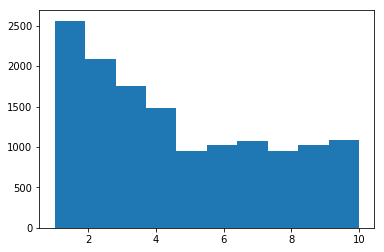

[2561.399 2087.692 1748.84  1478.249  944.839 1022.755 1078.439  950.139
 1029.349 1080.971]
All Hits 1.3983E+04
[5347412.201107463, 3651039.2772803963, 2585220.981160521, 2420109.6697606524, 1972532.821587918, 1652372.236760108, 966338.8114449463, 1102978.8794449903, 2433685.0844606548, 1983597.589187921, 1661641.0887601115, 978024.6295109489, 1112696.417878993, 0]
All Doublets 2.7868E+07


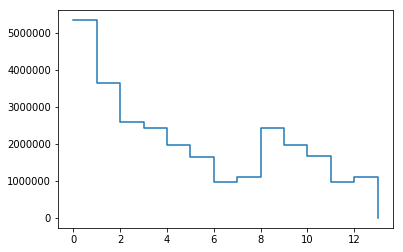

All triplets [9351768353.785784, 5397145160.600975, 5052443596.68196, 3449644299.706186, 2475179265.2960234, 1042137461.475881, 2017417805.9431248, 5080784881.347837, 3468994807.8757772, 2505111308.004462, 1057216261.7870855, 2041814194.8329737, 0]
4.2940E+10


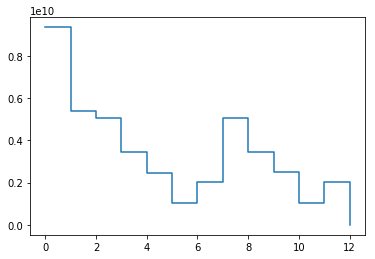

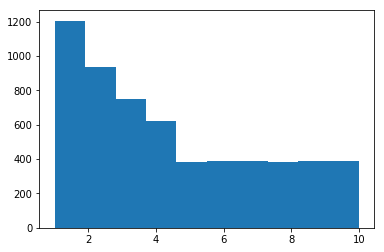

In [221]:
#print hits[hits['tkId']==3].head(50)
n,b,p = plt.hist(rawHits['seq'],weights=rawHits['norm'])
plt.show()
print n 
print 'All Hits', '{:.4E}'.format(np.sum(n))
doublets = [n[0]*n[1],n[1]*n[2],n[2]*n[3],
            n[0]*n[4],n[1]*n[4],n[2]*n[4],n[4]*n[5],n[5]*n[6],
            n[0]*n[7],n[1]*n[7],n[2]*n[7],n[7]*n[8],n[8]*n[9],0
           ]
print doublets
print 'All Doublets', '{:.4E}'.format(np.sum(doublets))
xy = np.arange(0.,14.,1.)
plt.step(xy,doublets,where='post')
plt.show()
triplets = [n[0]*n[1]*n[2],n[1]*n[2]*n[3],
            n[0]*n[1]*n[4],n[1]*n[2]*n[4],
            n[0]*n[4]*n[5],n[4]*n[5]*n[6],
            n[1]*n[4]*n[5],
            n[0]*n[1]*n[7],n[1]*n[2]*n[7],
            n[0]*n[7]*n[8],n[7]*n[8]*n[9],
            n[1]*n[7]*n[8],0
           ]
print 'All triplets', triplets
print '{:.4E}'.format(np.sum(triplets))
xy = np.arange(0.,len(triplets),1)
plt.step(xy,triplets,where='post')
plt.show()


plt.hist(hits['seq'],weights=hits['norm'])
plt.show()

1204739 932585 751813 619508 763058 779521 781967


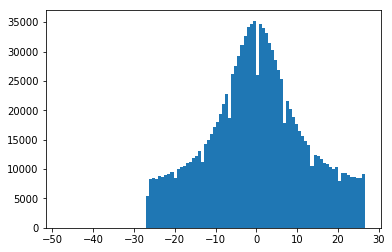

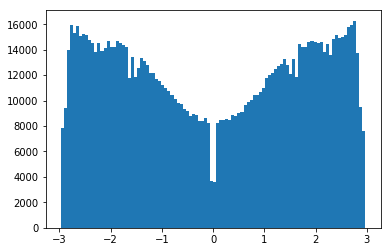

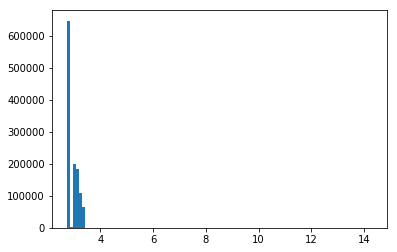

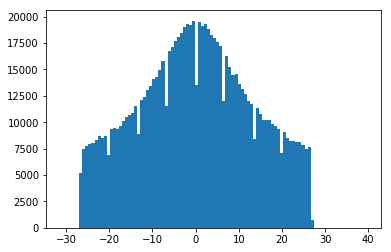

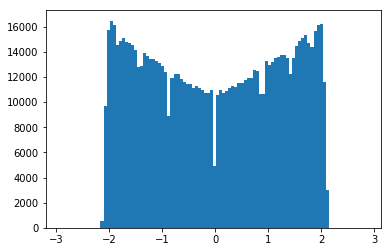

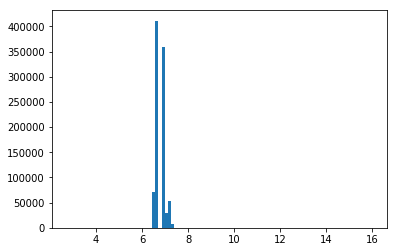

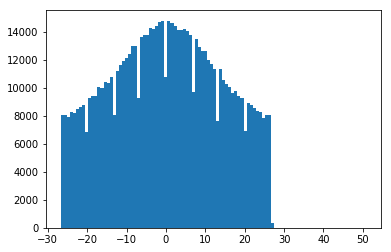

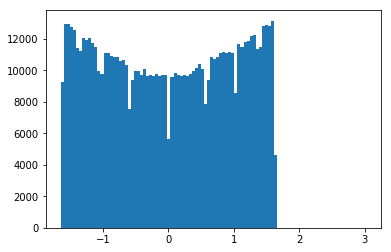

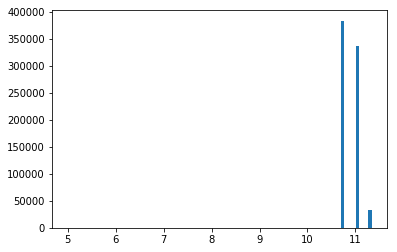

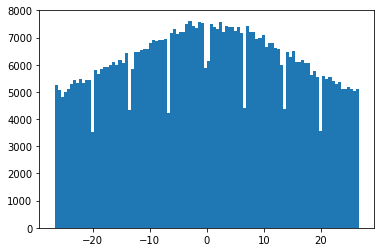

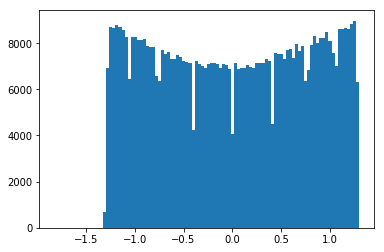

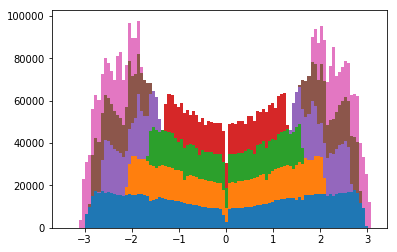

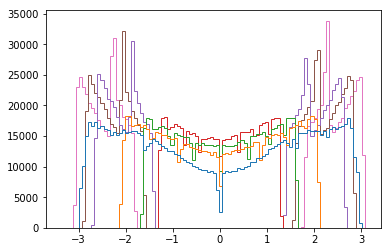

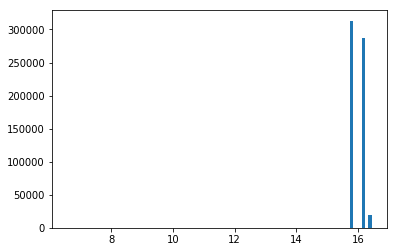

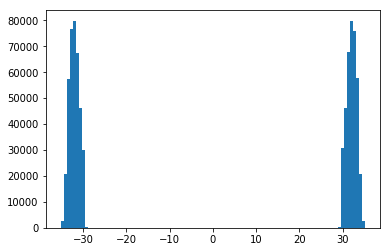

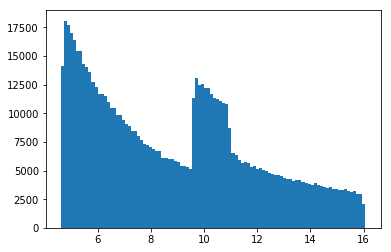

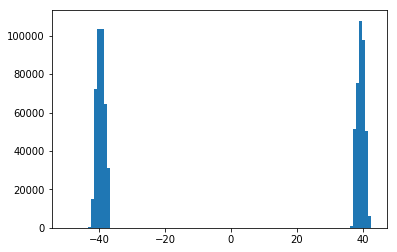

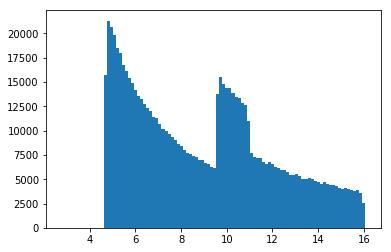

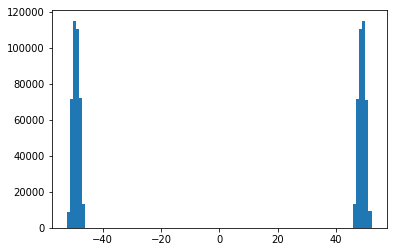

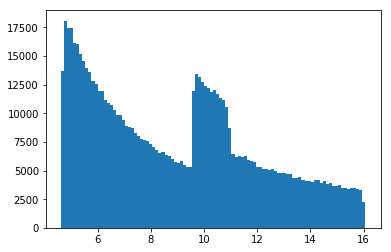

In [166]:
hb1 = hits.query('seq==1')
hb2 = hits.query('seq==2')
hb3 = hits.query('seq==3')
hb4 = hits.query('seq==4')
hf1 = hits.query('seq==5 or seq==8')
hf2 = hits.query('seq==6 or seq==9')
hf3 = hits.query('seq==7 or seq==10')

print len(hb1), len(hb2), len(hb3), len(hb4), len(hf1), len(hf2), len(hf3)
plt.hist(hb1['zg'],log=False, bins=100)
plt.show()
plt.hist(hb1['eta'],log=False, bins=100)
plt.show()
plt.hist(hb1['rg'],log=False, bins=100)
plt.show()
plt.hist(hb2['zg'],log=False, bins=100)
plt.show()
plt.hist(hb2['eta'],log=False, bins=100)
plt.show()
plt.hist(hb2['rg'],log=False, bins=100)
plt.show()
plt.hist(hb3['zg'],log=False, bins=100)
plt.show()
plt.hist(hb3['eta'],log=False, bins=100)
plt.show()
plt.hist(hb3['rg'],log=False, bins=100)
plt.show()
plt.hist(hb4['zg'],log=False, bins=100)
plt.show()
plt.hist(hb4['eta'],log=False, bins=100)
plt.show()
data = [hb1['eta'],hb2['eta'],hb3['eta'],hb4['eta'],hf1['eta'],hf2['eta'],hf3['eta']]
plt.hist(data,log=False, bins=100, histtype='barstacked')
plt.show()
plt.hist(data,log=False, bins=100, histtype='step')
plt.show()


plt.hist(hb4['rg'],log=False, bins=100)
plt.show()
plt.hist(hf1['zg'],log=False, bins=100)
plt.show()
plt.hist(hf1['rg'],log=False, bins=100)
plt.show()
plt.hist(hf2['zg'],log=False, bins=100)
plt.show()
plt.hist(hf2['rg'],log=False, bins=100)
plt.show()
plt.hist(hf3['zg'],log=False, bins=100)
plt.show()
plt.hist(hf3['rg'],log=False, bins=100)
plt.show()


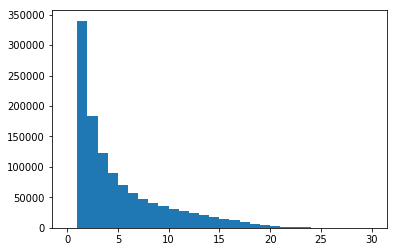

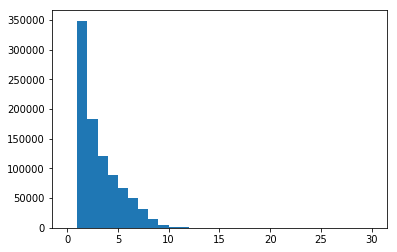

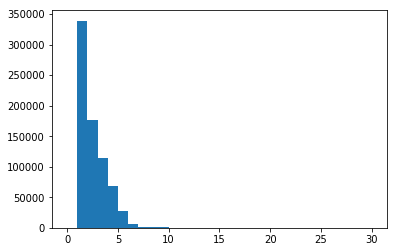

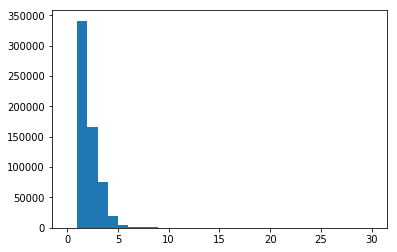

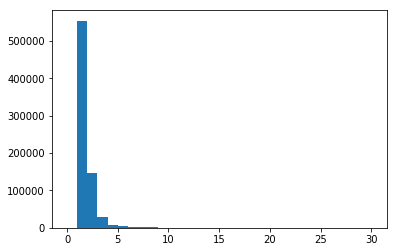

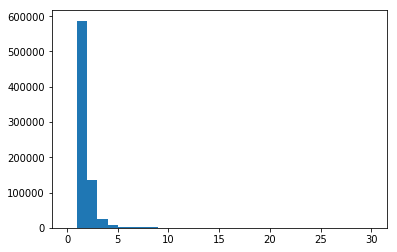

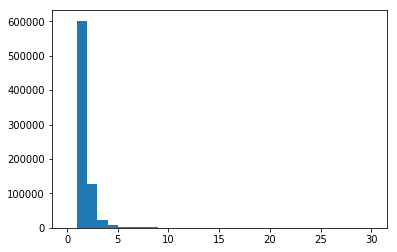

In [167]:
plt.hist(hb1['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hb2['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hb3['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hb4['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hf1['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hf2['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()
plt.hist(hf3['ysize']/8.,log=False, bins=30,range=[0,30])
plt.show()

In [168]:
print 'min/max'
print hb1.agg(['min','max'])
print hb2.agg(['min','max'])
print hb3.agg(['min','max'])
print hb4.agg(['min','max'])
print hf1.agg(['min','max'])
print hf2.agg(['min','max'])
print hf3.agg(['min','max'])

min/max
       ev   ind  det   charge        xg        yg         zg         rg  \
min     1     0    0     2019 -3.158685 -3.374328 -47.909229   2.738755   
max  1000  4379   95  8107997  3.158685  9.439112  26.674952  14.278748   

      iphi  xsize     ...         tkId      pt   n1   tkId2     pt2   n2  \
min -32766  -1023     ...            0     401    1       0       0    0   
max  32765   1023     ...       142904  292338  355  142143  196301  313   

          phi       eta  seq      trackID  
min -3.141570 -2.971995    1     10000000  
max  3.141403  2.971991    1  10000114179  

[2 rows x 21 columns]
       ev   ind  det   charge        xg         yg         zg         rg  \
min     1  1305   96     4021 -6.980564 -14.810458 -31.160593   2.738874   
max  1000  8045  319  5558487  9.779302  12.969457  39.338615  15.979434   

      iphi  xsize     ...         tkId      pt   n1   tkId2     pt2  n2  \
min -32767  -1023     ...            0     401    0       0       0   0   
max

In [169]:
def build(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['zg'],
                    'r'+n : hh['rg'],
                    'phi'+n : hh['phi'],
                    'ys'+n : hh['ysize'],
                    'pt'+n : hh['pt'],
                    'det'+n : hh['det'],
                    'trackID' : hh['trackID']
                       })

def buildXYZ(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['zg'],
                    'x'+n : hh['xg'],
                    'y'+n : hh['yg'],
                    'pt'+n : hh['pt'],
                    'det'+n : hh['det'],
                    'phi'+n : hh['phi'],
                    'trackID' : hh['trackID']
                       })


In [170]:
def fishBone(hi,hj) :
    mpt=600
#    maxc = 1000./(mpt*87.)
    fb = pd.merge(pd.merge(buildXYZ(hi,'0'),buildXYZ(hj,'1'),on='trackID'),buildXYZ(hj,'2'),on='trackID')
#    pc = phicut(quadc['r1'],quadc['r2'],maxc)
#  d1 = (quadc['phi2']-quadc['phi1'])/pc
    cut = np.logical_and(abs(fb['phi0']-fb['phi1'])<0.05,abs(fb['phi0']-fb['phi2'])<0.05)
    cut = np.logical_and(cut,fb['pt0']>mpt)
    return fb[np.logical_and(cut,fb['det1']<fb['det2'])]
    
def sdiff(fb) :
    n1 = (fb['x1']-fb['x0'])*(fb['x1']-fb['x0'])+\
    (fb['y1']-fb['y0'])*(fb['y1']-fb['y0'])+\
    (fb['z1']-fb['z0'])*(fb['z1']-fb['z0'])
    n2 = (fb['x2']-fb['x0'])*(fb['x2']-fb['x0'])+\
    (fb['y2']-fb['y0'])*(fb['y2']-fb['y0'])+\
    (fb['z2']-fb['z0'])*(fb['z2']-fb['z0'])
    pr = (fb['x1']-fb['x0'])*(fb['x2']-fb['x0'])+\
      (fb['y1']-fb['y0'])*(fb['y2']-fb['y0'])+\
      (fb['z1']-fb['z0'])*(fb['z2']-fb['z0'])
    return pr/np.sqrt(n1*n2)

In [171]:
def plotFB(h1,h2) :
  f12 = fishBone(h1,h2)
  # print f12.head()
  d = sdiff(f12)
  plt.hist(d, bins=100,log=True)
  plt.show()
  plt.hist(d[d>.995], bins=100,log=True)
  plt.show()
  plt.hist(d[d>.9999], bins=100,log=True)
  plt.show()

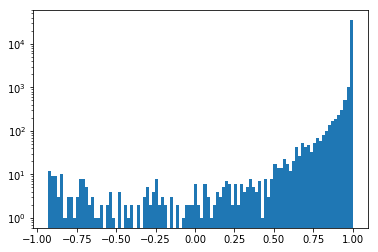

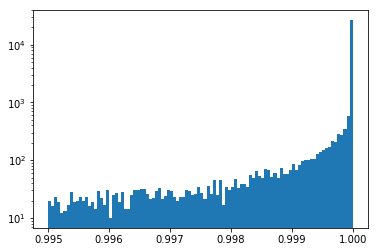

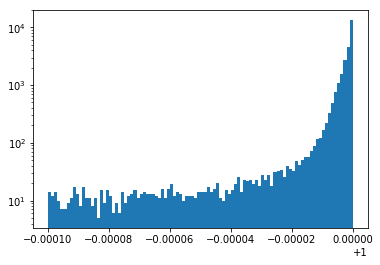

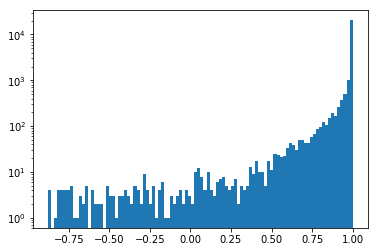

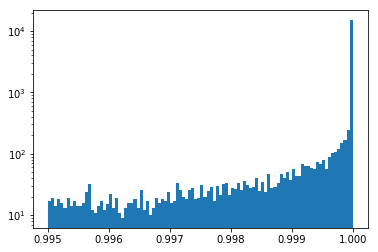

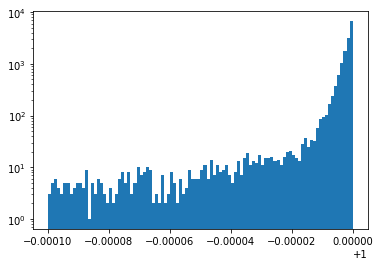

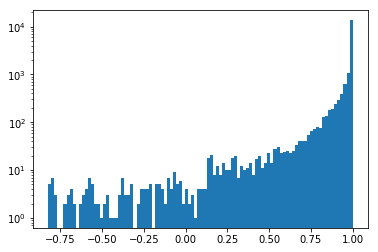

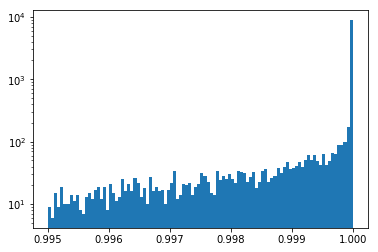

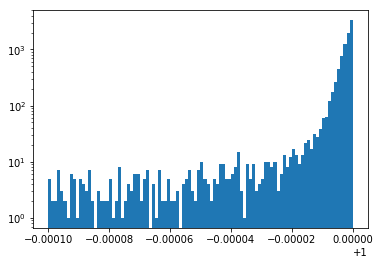

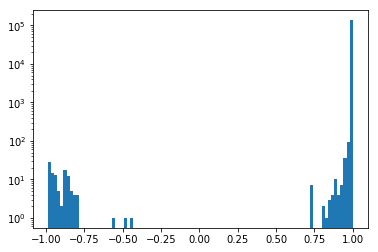

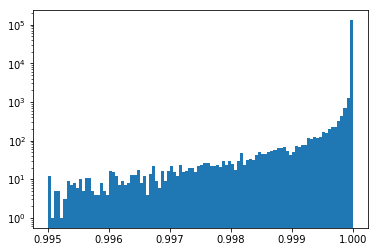

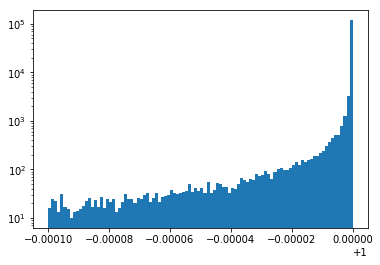

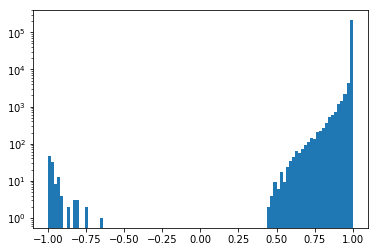

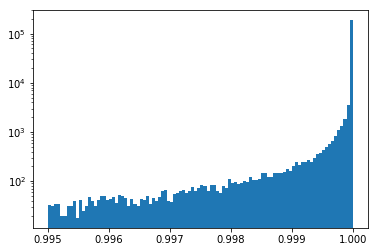

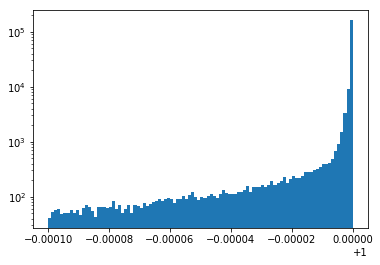

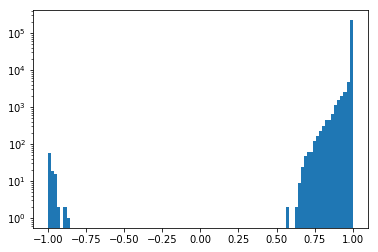

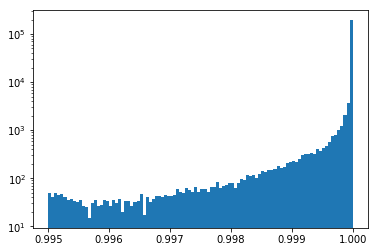

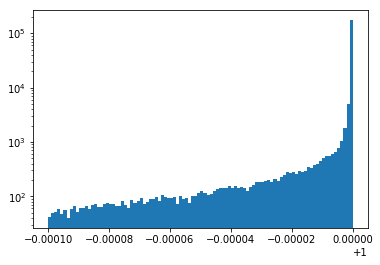

In [172]:
plotFB(hb1,hb2)
plotFB(hb2,hb3)
plotFB(hb3,hb4)
plotFB(hb1,hf1)
plotFB(hf1,hf2)
plotFB(hf2,hf3)

In [173]:
t12 = pd.merge(build(hb1,'1'),build(hb2,'2'),on='trackID')
t23 = pd.merge(build(hb2,'1'),build(hb3,'2'),on='trackID')
t34 = pd.merge(build(hb3,'1'),build(hb4,'2'),on='trackID')
t123 = pd.merge(t12,build(hb3,'3'),on='trackID')
print len(t12)
print len(t23)
print len(t34)
print len(t123)
t1234 = pd.merge(t123,build(hb4,'4'),on='trackID')
print len(t1234)
t1231 = pd.merge(t123,build(hf1,'4'),on='trackID')
print len(t1231)
t121 = pd.merge(t12,build(hf1,'3'),on='trackID')
t1212 = pd.merge(t121,build(hf2,'4'),on='trackID')
print len(t1212)
t11 = pd.merge(build(hb1,'1'),build(hf1,'2'),on='trackID')
t112 = pd.merge(t11,build(hf2,'3'),on='trackID')
t1123 = pd.merge(t112,build(hf3,'4'),on='trackID')
print len(t1123)
print 'pentuplets'
t12123 = pd.merge(t1212,build(hf3,'5'),on='trackID')
print len(t12123)

# try to get triplets in gap
print 'triplets'
t1230 = pd.merge(t123,build(hb4,'4'),on='trackID',how='left')
t1230 = t1230[t1230.isnull()['z4']]
print len(t1230)
t1230 = pd.merge(t1230,build(hf1,'5'),on='trackID',how='left')
t1230 = t1230[t1230.isnull()['z5']]
print len(t1230)

qall = pd.concat([t1234,t1231,t1212,t1123])
print len(qall)
print t1234.head()
print t1231.head()
print t1212.head()
print t1123.head()
print t1230.head()
print t12123.head()

1119054
1023158
879245
1686712
4892329
1127517
933900
1796774
pentuplets
1272044
triplets
212084
90346
8750520
   det1      phi1    pt1        r1   trackID  ys1        z1  det2      phi2  \
0    19  1.471751  12402  3.311650  10000000   17 -4.949985   146  1.473213   
1    19  1.490899  11881  3.321660  10000001   28 -4.962011   146  1.492998   
2    19  1.508659   1116  3.332094  10000002   15 -3.228904   147  1.529033   
3    11  0.957661   1220  2.772534  10000003   31 -5.223804   130  0.937362   
4    43  2.933400    480  2.740693  10000005   14 -2.197470   195  2.887583   

     pt2    ...        pt3         r3  ys3         z3  det4      phi4    pt4  \
0  12402    ...      12402  11.309768   21 -14.069117   793  1.477370  12402   
1  11881    ...      11881  11.306963   18 -14.051542   793  1.497169  11881   
2   1116    ...       1116  11.323120   15  -8.101905   802  1.574145   1116   
3   1220    ...       1220  11.037246   23 -17.280849   744  0.894308   1220   
4    480    ..

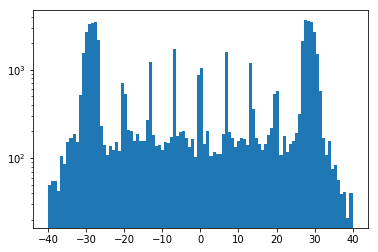

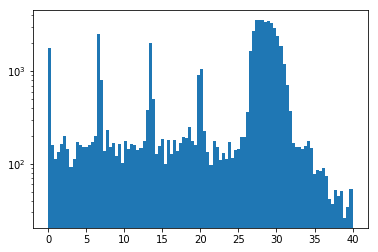

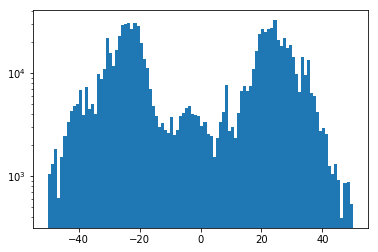

In [174]:
hole = zAtR(t1230[t1230['pt3']>600],16)
plt.hist(hole[abs(hole)<40],log=True, bins=100)
plt.show()
plt.hist(abs(hole[abs(hole)<40]),log=True, bins=100)
plt.show()
penta = zAtR(t12123[t12123['pt3']>600],6.5)
plt.hist(penta[abs(penta)<50],log=True, bins=100)
plt.show()

In [175]:
def plotTriplets(quad,mpt) :
    
  d1 = (quad['r1']*quad['z2']-quad['z1']*quad['r2'])/(quad['r1']-quad['r2'])
  d2 = (quad['r2']*quad['z3']-quad['z2']*quad['r3'])/(quad['r2']-quad['r3'])
  d3 = (quad['r3']*quad['z4']-quad['z3']*quad['r4'])/(quad['r3']-quad['r4'])
  
  z0cut = np.logical_and(abs(d1)<10.,np.logical_and(abs(d2)<10.,abs(d3)<10.))

  quadc = quad[np.logical_and(z0cut,quad['pt1']>mpt)]

#  print 'dpt'
#  plt.hist(quad['pt1']-quad['pt2'],log=True, bins=100)
#  plt.show()
#  plt.hist(quad['pt2']-quad['pt3'],log=True, bins=100)
#  plt.show()
#  plt.hist(quad['pt3']-quad['pt4'],log=True, bins=100)
#  plt.show()


  print 'delta123', len(quadc)
  
#dt,dtn = ml(t123['tpt'],t123['tpz'],t123['tpt2'],t123['tpz2'])
#plt.hist(dt[dt<0.1], log=True, bins=100)
#plt.show()
#plt.hist(dtn[dtn<0.1], log=True, bins=100)
#plt.show()

    
  thcut = alignRZ(quadc,'r',0.6,True)
  pzcut = alignRZ(quadc,'phi',1.0,True)
  thcut2 = alignRPZ(quadc,'r',True)
  pzcut2 = alignRPZ(quadc,'phi',True)

  dc = dca(quadc,True)
  curv1 = dca(quadc,True,True)
  field = curv1-1/(0.087*quadc['pt1'])
  print 'field'
  plt.hist(field[abs(field)<5],log=True, bins=100)
  plt.show()
  print 'thcut,pzcut,dcacut',len(thcut)
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.3],log=True, bins=100)
  plt.show()

  print 'thcut2,pzcut2',len(thcut2)
  plt.hist(thcut2[abs(thcut2)<0.6],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.2],log=True, bins=100)
  plt.show()
 
  print 'delta234'

  thcut = alignRZ(quadc,'r',0.6,False)
  pzcut = alignRZ(quadc,'phi',1.0,False)
  thcut2 = alignRPZ(quadc,'r',False)
  pzcut2 = alignRPZ(quadc,'phi',False)
  dc = dca(quadc,False)
  curv2 = dca(quadc,False,True)
  field =curv2 -1/(0.087*quadc['pt1'])
  print 'field'
  plt.hist(field[abs(field)<5],log=True, bins=100)
  plt.show()
  print 'delta curv'
  dcu = curv2-curv1
  plt.hist(dcu[abs(dcu)<0.15],log=True, bins=100)
  plt.show()  
  print 'thcut,pzcut,dcacut',len(thcut)
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.3],log=True, bins=100)
  plt.show()

    
  print 'thcut2,pzcut2',len(thcut2)
  plt.hist(thcut2[abs(thcut2)<0.6],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.2],log=True, bins=100)
  plt.show()


In [238]:
def plotDoublets(quad,mpt) :
  quadc = quad[quad['pt1']>mpt]

  maxc = 1000./(mpt*87.)

  print 'dphi'
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[abs(d1)<.1], bins=100,log=True)
  plt.show()
  d2 = quadc['phi3']-quadc['phi2']
  plt.hist(d2[abs(d2)<.1], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[abs(d3)<.1], bins=100,log=True)
  plt.show()

  pcut = np.logical_and(abs(d1)<0.05,np.logical_and(abs(d2)<0.05,abs(d3)<0.05))


  print 'dphiNor'
    
  pc = phicut(quadc['r1'],quadc['r2'],maxc)
  d1 = (quadc['phi2']-quadc['phi1'])/pc
  plt.hist(d1[abs(d1)<2.], bins=100,log=True)
  plt.show()
  pc = phicut(quadc['r2'],quadc['r3'],maxc)
  d2 = (quadc['phi3']-quadc['phi2'])/pc
  plt.hist(d2[abs(d2)<2.], bins=100,log=True)
  plt.show()
  pc = phicut(quadc['r3'],quadc['r4'],maxc)
  d3 = (quadc['phi4']-quadc['phi3'])/pc
  plt.hist(d3[abs(d3)<2.], bins=100,log=True)
  plt.show()


  print 'zinner'
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print 'dz'
  d1 = quadc['z2']-quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z3']-quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z4']-quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print 'z0'
  d1 = (quadc['r1']*quadc['z2']-quadc['z1']*quadc['r2'])/(quadc['r1']-quadc['r2'])
  plt.hist(d1[np.logical_and(pcut,abs(d1)<50)], bins=100,log=True)
  plt.show()
  d2 = (quadc['r2']*quadc['z3']-quadc['z2']*quadc['r3'])/(quadc['r2']-quadc['r3'])
  plt.hist(d2[np.logical_and(pcut,abs(d2)<50)], bins=100,log=True)
  plt.show()
  d3 = (quadc['r3']*quadc['z4']-quadc['z3']*quadc['r4'])/(quadc['r3']-quadc['r4'])
  plt.hist(d3[np.logical_and(pcut,abs(d3)<50)], bins=100,log=True)
  plt.show()
  

  pcut = np.logical_and(abs(d1)<10.,np.logical_and(abs(d2)<10.,abs(d3)<10.))


  print 'dr'
  d1 = quadc['r2']-quadc['r1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<20)], bins=100,log=True)
  plt.show()
  d2 = quadc['r3']-quadc['r2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<20)], bins=100,log=True)
  plt.show()
  d3 = quadc['r4']-quadc['r3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<20)], bins=100,log=True)
  plt.show()

  print 'dphi zcut'
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<.1)], bins=100,log=True)
  plt.show()
  d2 = quadc['phi3']-quadc['phi2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<.1)], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<.1)], bins=100,log=True)
  plt.show()

  print 'zinner zcut'
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print 'module'
  d1 = quadc['det1']
  plt.hist(d1[pcut], range=[0,96], bins=96, log=False)
  plt.show()
  d2 = quadc['det2']
  plt.hist(d2[pcut], range=[0,2000], bins=2000, log=False)
  plt.show()
  d3 = quadc['det3']
  plt.hist(d3[pcut], range=[0,2000], bins=2000, log=False)
  plt.show()



  norm = 1./8.
  print 'dysize'
  d1 = (quadc['ys2']-quadc['ys1'])*norm
  c = np.logical_and(quadc['ys2']>0,quadc['ys1']>0)
  plt.hist(d1[np.logical_and(pcut,c)], range=[-8,8],bins=32,log=True)
  plt.show()
  c = np.logical_and(quadc['ys2']>0,quadc['ys3']>0)
  d2 = (quadc['ys3']-quadc['ys2'])*norm
  plt.hist(d2[np.logical_and(pcut,c)], range=[-6,6],bins=26,log=True)
  plt.show()
  c = np.logical_and(quadc['ys4']>0,quadc['ys3']>0)
  d3 = (quadc['ys4']-quadc['ys3'])*norm
  plt.hist(d3[np.logical_and(pcut,c)], range=[-6,6],bins=26,log=True)
  plt.show()

    
  print 'ysize'
  d1 = quadc['ys1']*norm
  plt.hist(d1[pcut], bins=30,range=[0,30],log=True)
  plt.show()
  d2 = quadc['ys2']*norm
  plt.hist(d2[pcut], bins=30,range=[0,30],log=True)
  plt.show()
  d3 = quadc['ys3']*norm
  plt.hist(d3[pcut], bins=30,range=[0,30],log=True)
  plt.show()
 
  print 'ys-pred'
  th = 0.0285
  ptc = 0.015
  fac = th/ptc
  d1 = fac*(quadc['z1']-quadc['z2'])/(quadc['r1']-quadc['r2'])
  d1 = quadc['ys1']*norm - abs(d1)
  plt.hist(d1[np.logical_and(pcut,quadc['ys1']>0)], range=[-8,8],bins=32,log=True)
  plt.show()
  d2 = fac*(quadc['z3']-quadc['z2'])/(quadc['r3']-quadc['r2'])
  d2 = quadc['ys2']*norm - abs(d2)
  plt.hist(d2[np.logical_and(pcut,quadc['ys2']>0)], range=[-8,8],bins=32,log=True)
  plt.show()
  d3 = fac*(quadc['z3']-quadc['z4'])/(quadc['r3']-quadc['r4'])
  d3 = quadc['ys3']*norm - abs(d3)
  plt.hist(d3[np.logical_and(pcut,quadc['ys3']>0)], range=[-8,8],bins=32,log=True)
  plt.show()

    

delta123 480048
field


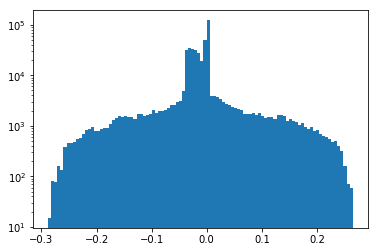

thcut,pzcut,dcacut 480048


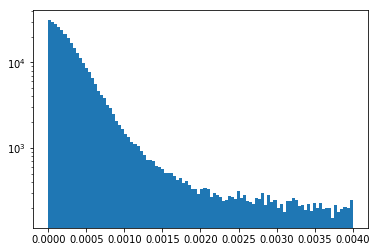

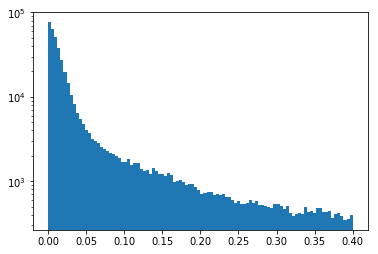

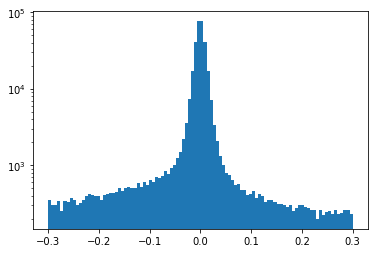

thcut2,pzcut2 480048


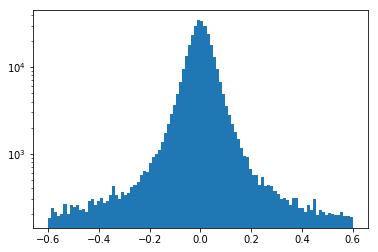

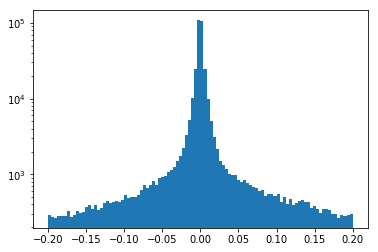

delta234
field


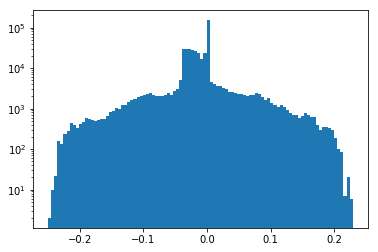

delta curv


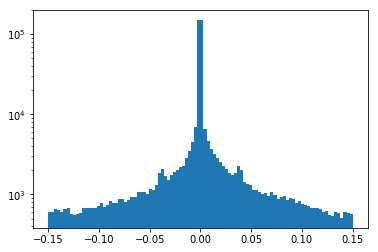

thcut,pzcut,dcacut 480048


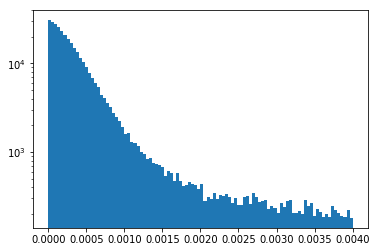

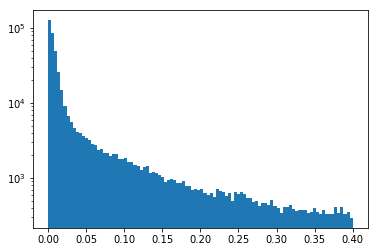

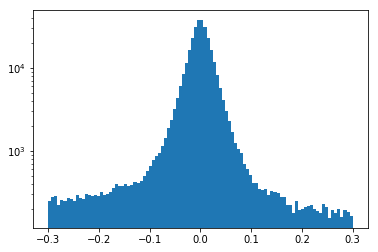

thcut2,pzcut2 480048


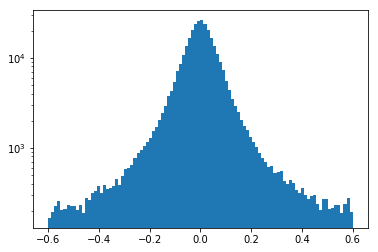

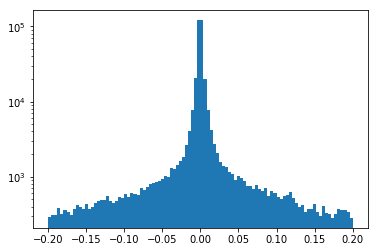

delta123 76745
field


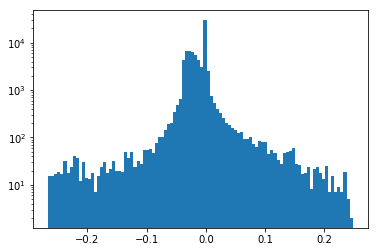

thcut,pzcut,dcacut 76745


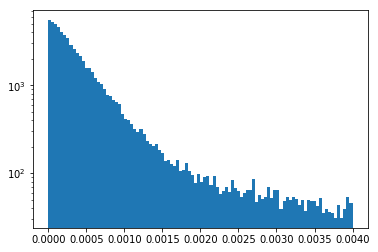

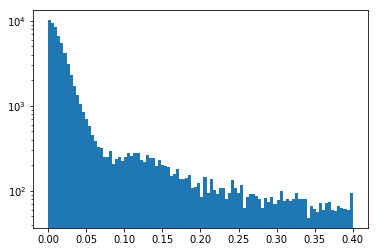

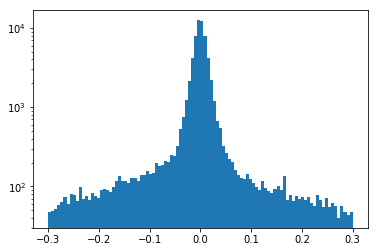

thcut2,pzcut2 76745


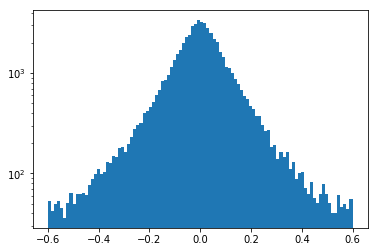

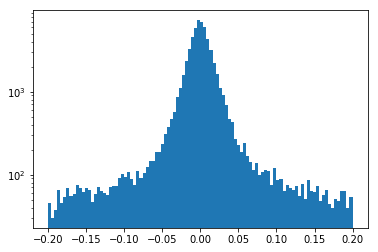

delta234
field


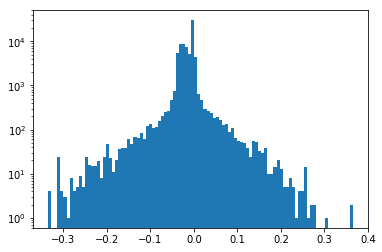

delta curv


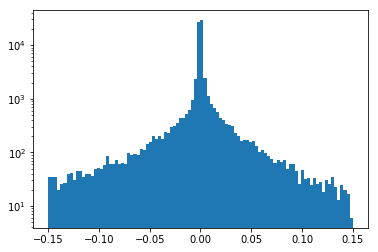

thcut,pzcut,dcacut 76745


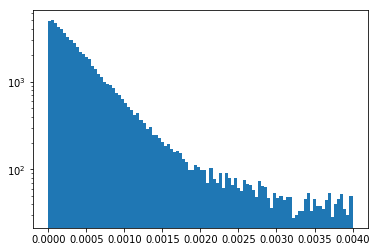

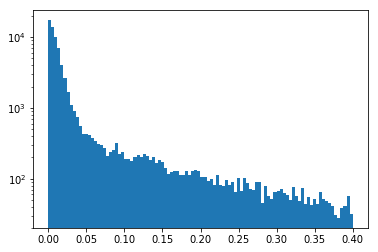

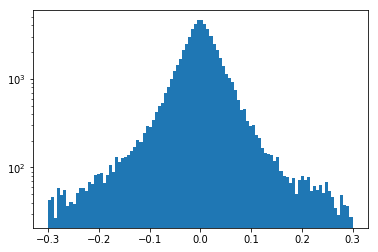

thcut2,pzcut2 76745


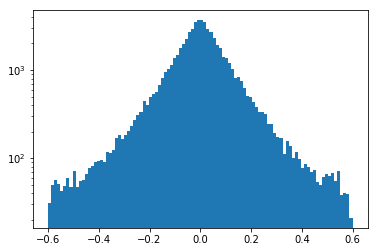

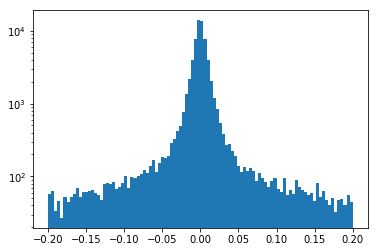

delta123 274344
field


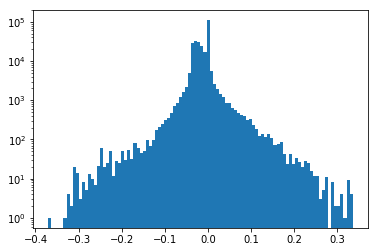

thcut,pzcut,dcacut 274344


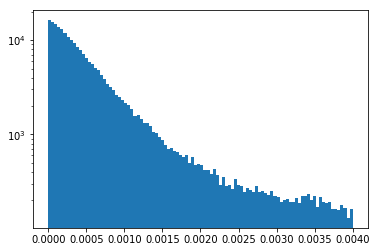

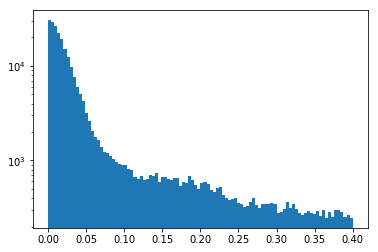

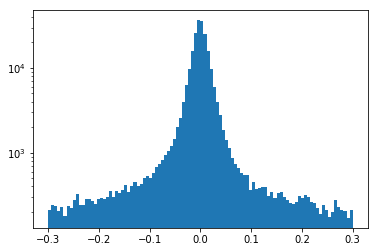

thcut2,pzcut2 274344


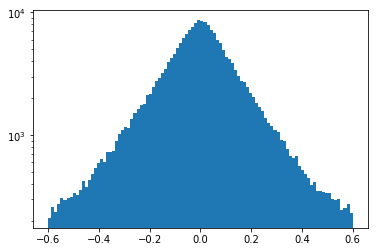

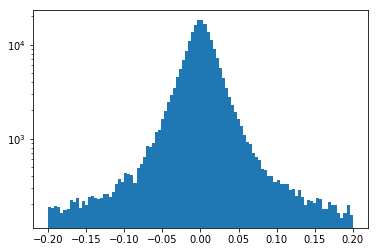

delta234
field


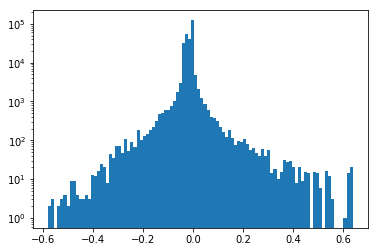

delta curv


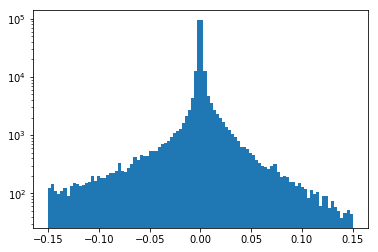

thcut,pzcut,dcacut 274344


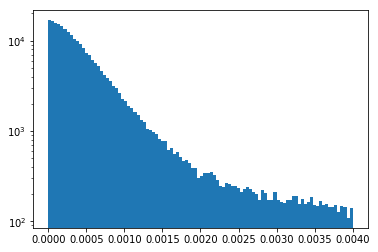

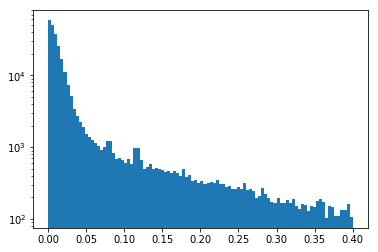

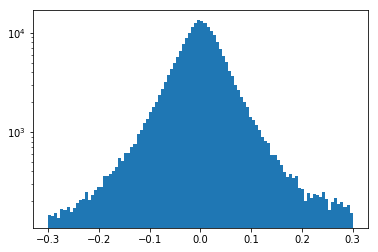

thcut2,pzcut2 274344


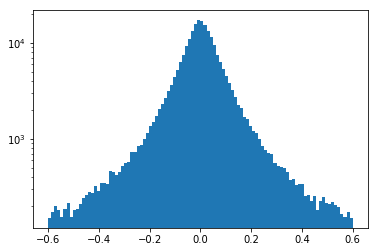

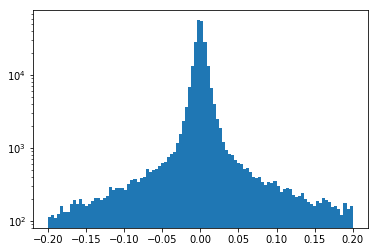

delta123 747101
field


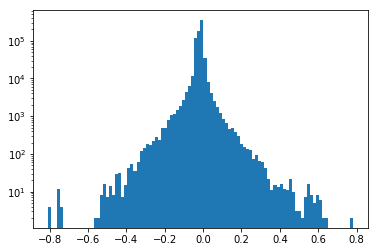

thcut,pzcut,dcacut 747101


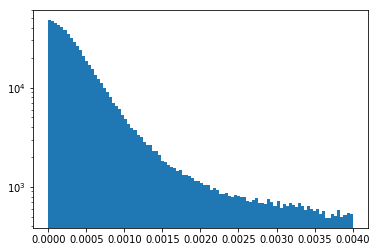

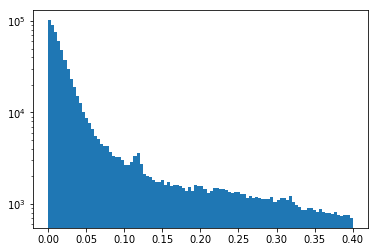

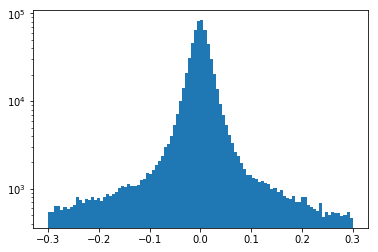

thcut2,pzcut2 747101


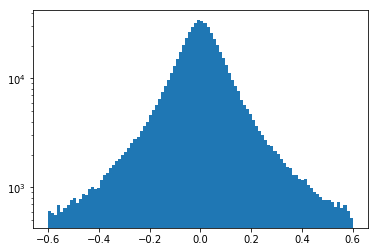

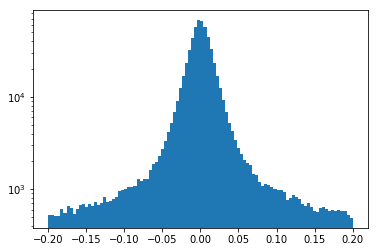

delta234
field


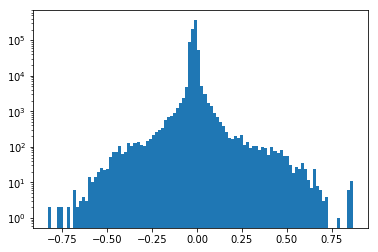

delta curv


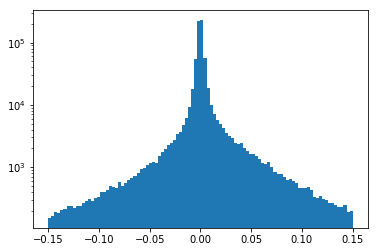

thcut,pzcut,dcacut 747101


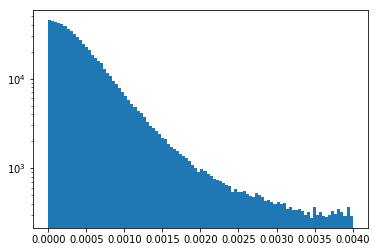

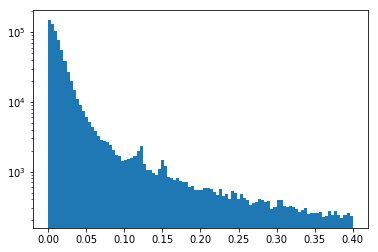

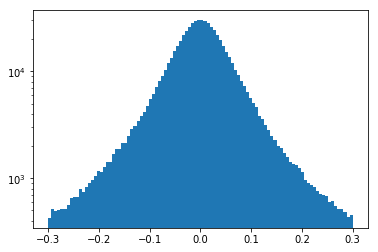

thcut2,pzcut2 747101


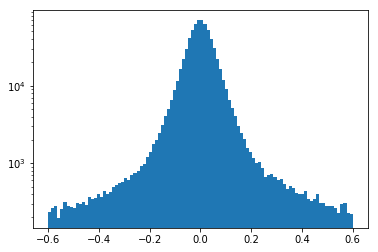

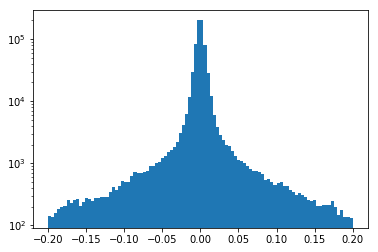

In [239]:
for quad in [t1234,t1231,t1212,t1123] :
    plotTriplets(quad,600)

dphi


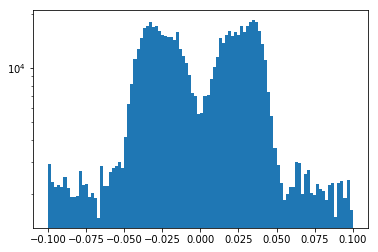

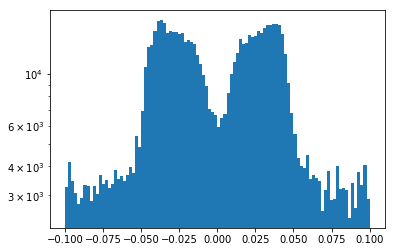

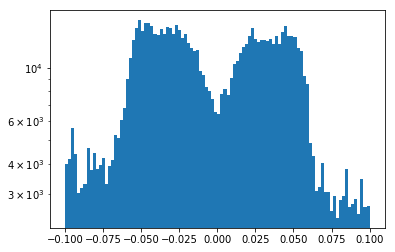

dphiNor


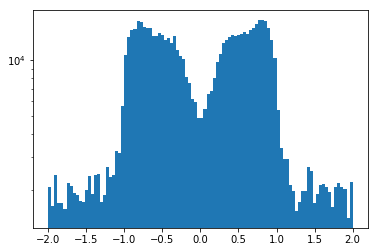

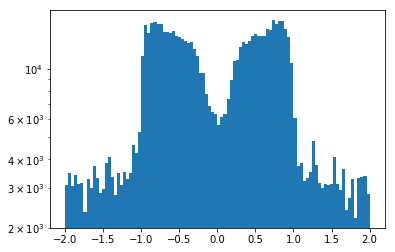

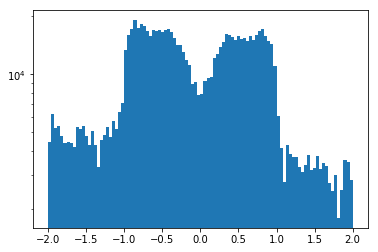

zinner


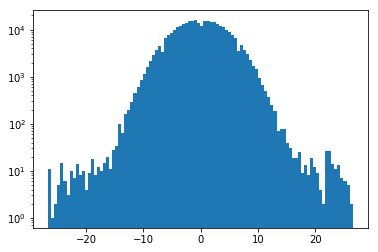

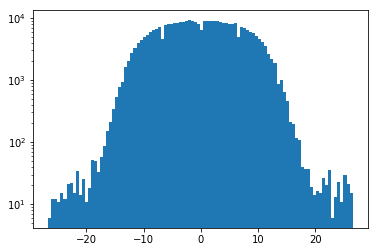

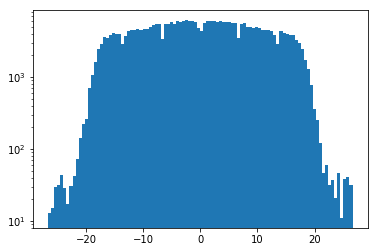

dz


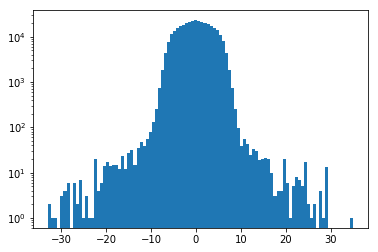

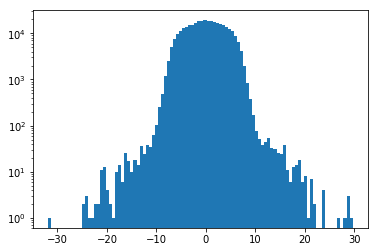

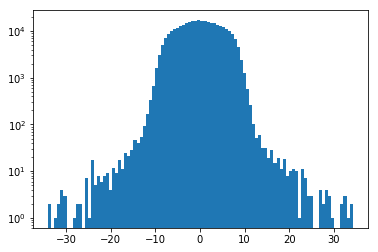

z0


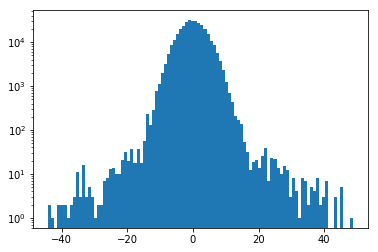

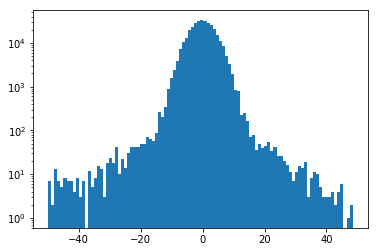

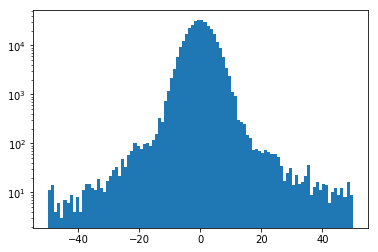

dr


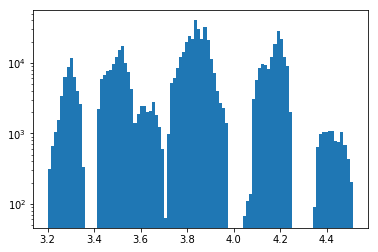

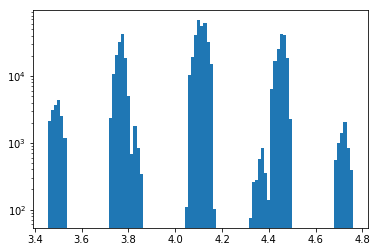

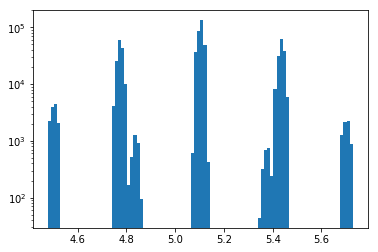

dphi zcut


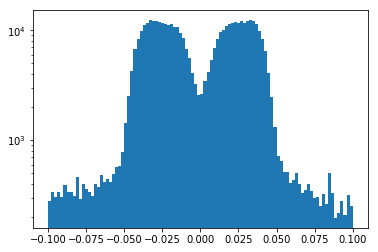

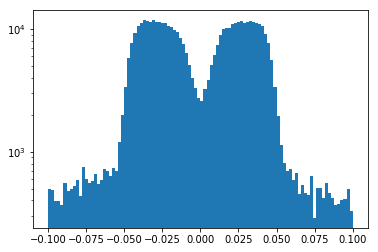

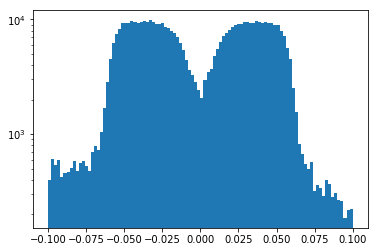

zinner zcut


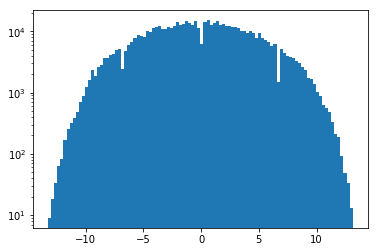

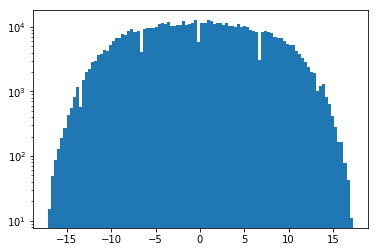

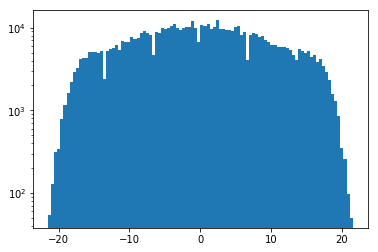

module


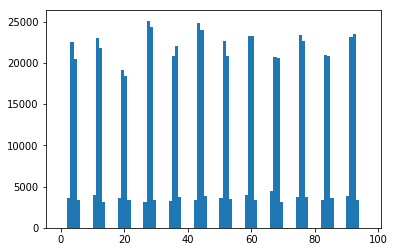

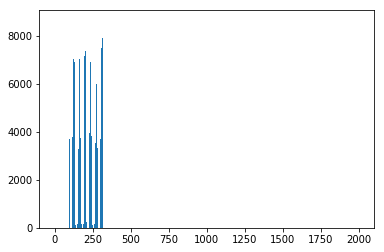

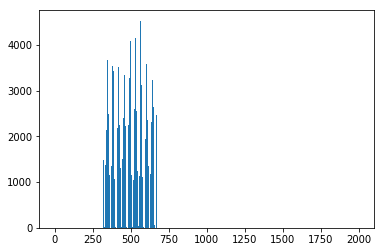

dysize


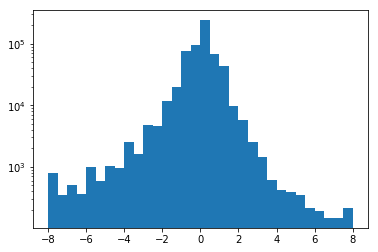

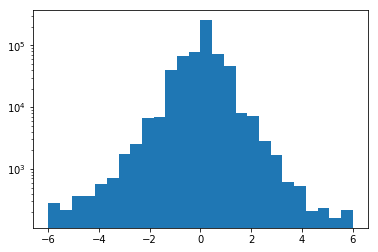

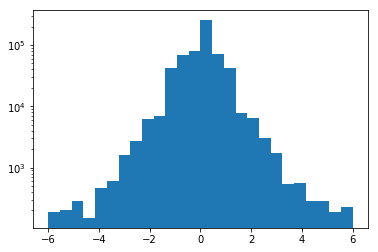

ysize


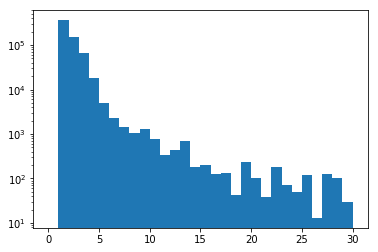

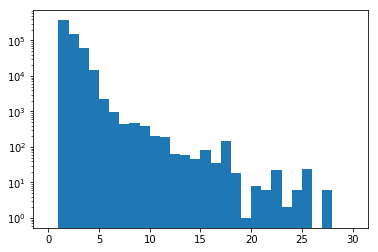

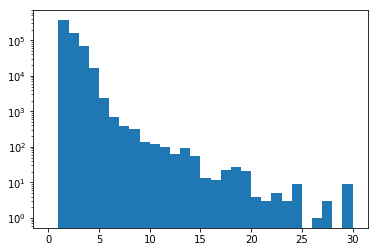

ys-pred


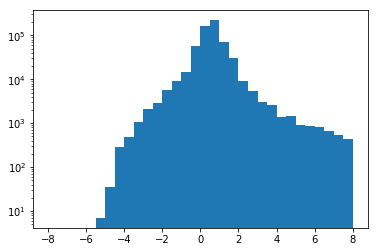

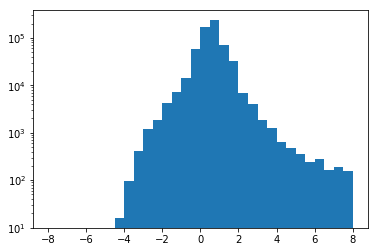

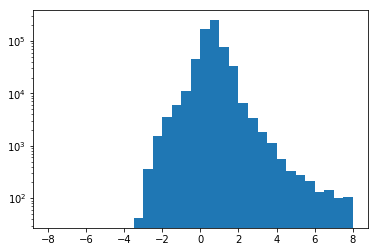

dphi


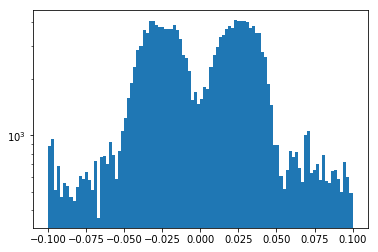

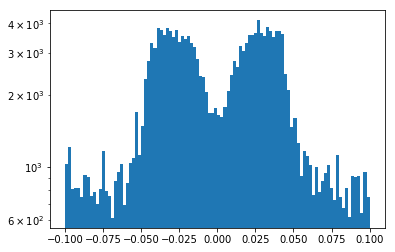

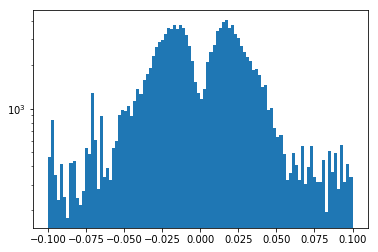

dphiNor


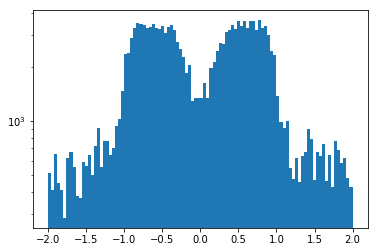

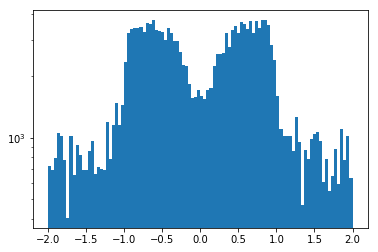

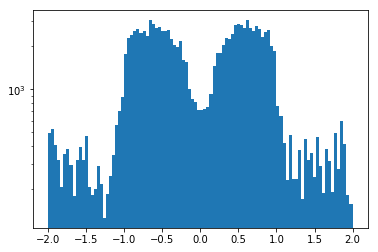

zinner


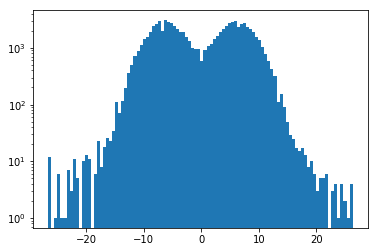

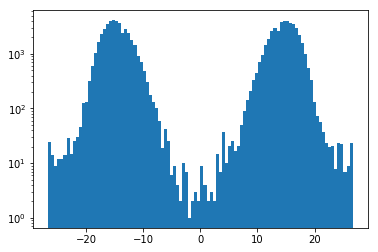

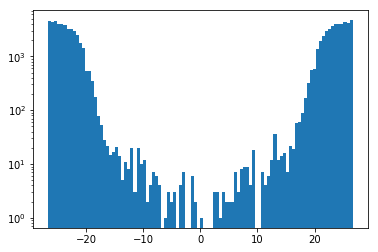

dz


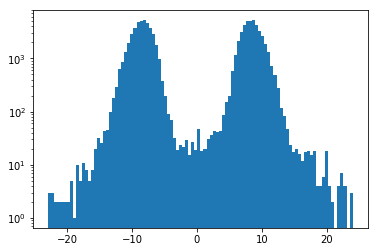

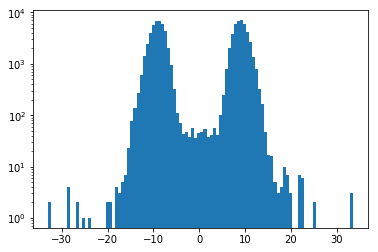

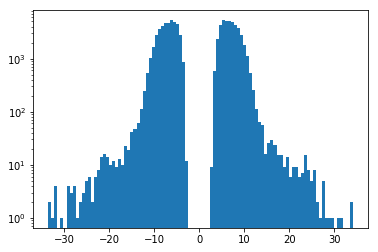

z0


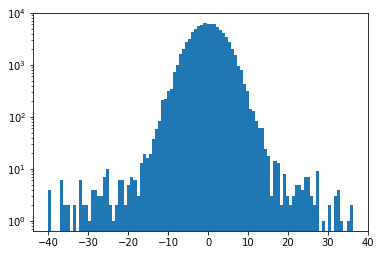

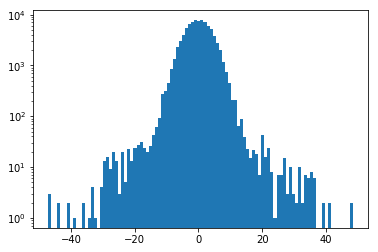

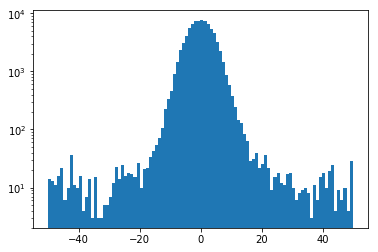

dr


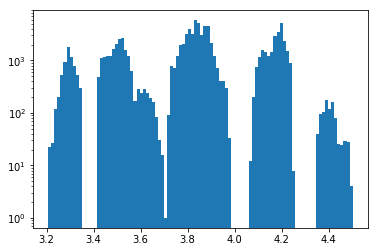

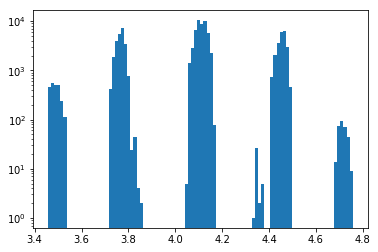

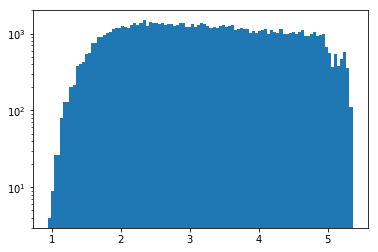

dphi zcut


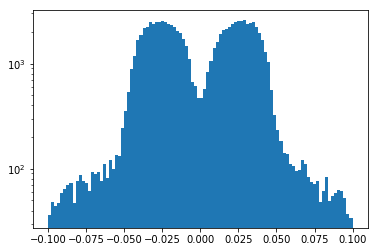

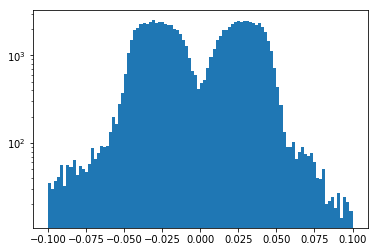

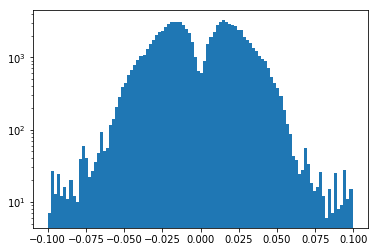

zinner zcut


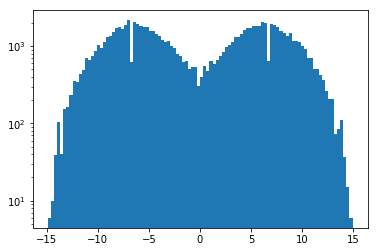

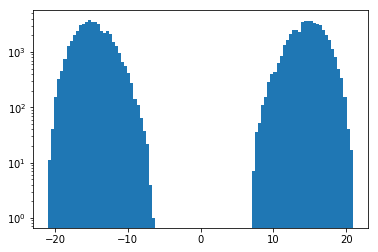

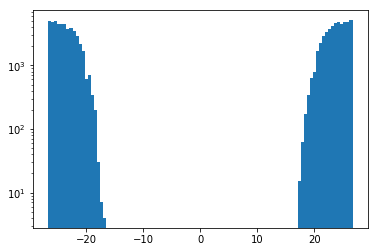

module


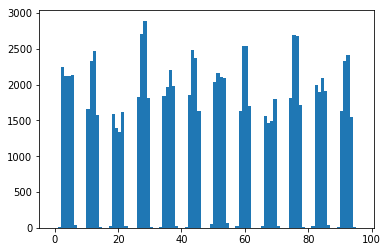

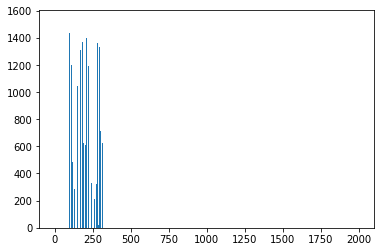

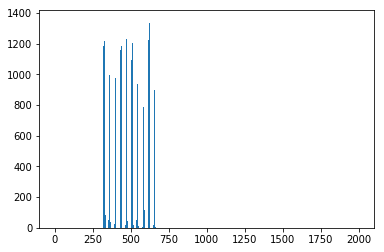

dysize


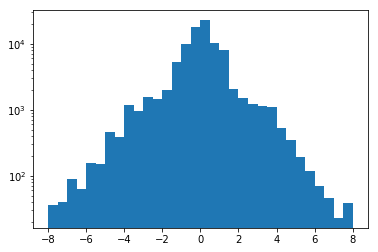

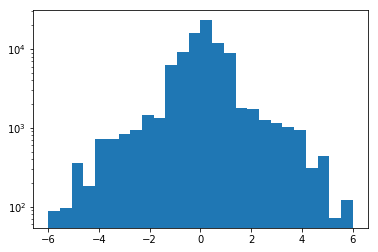

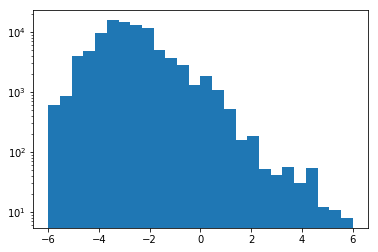

ysize


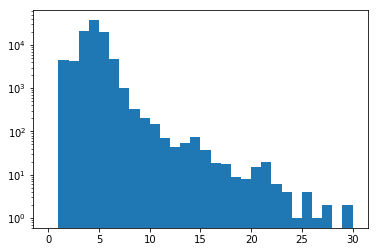

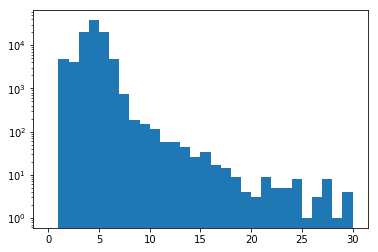

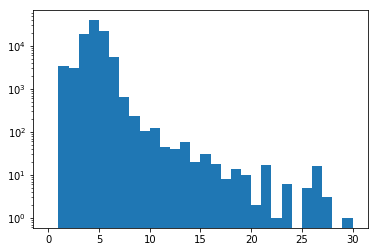

ys-pred


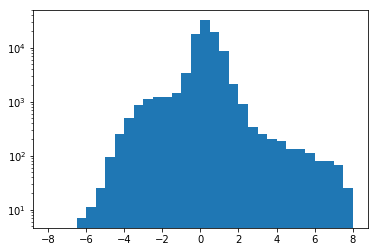

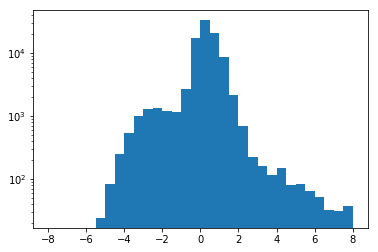

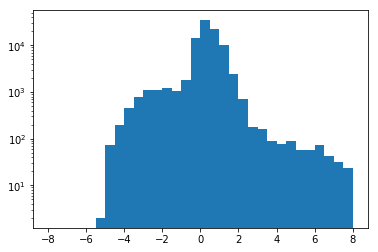

dphi


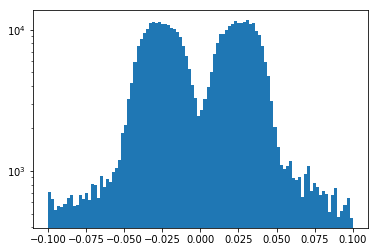

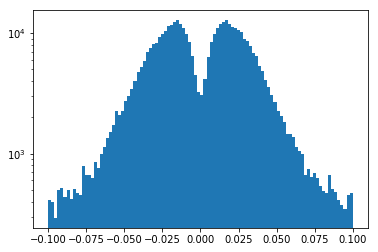

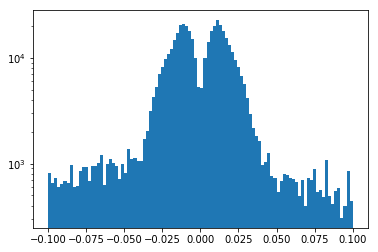

dphiNor


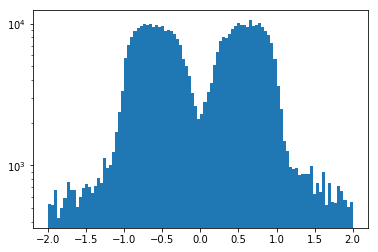

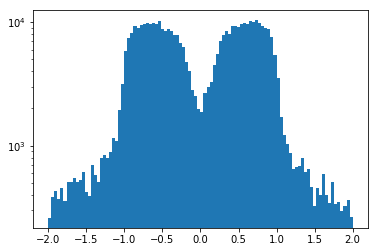

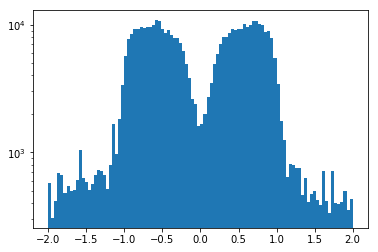

zinner


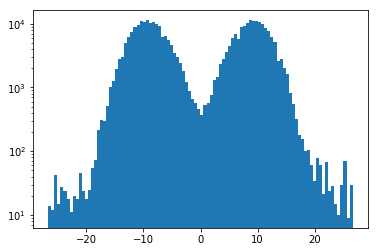

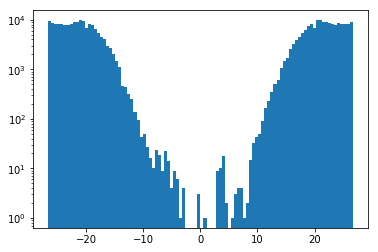

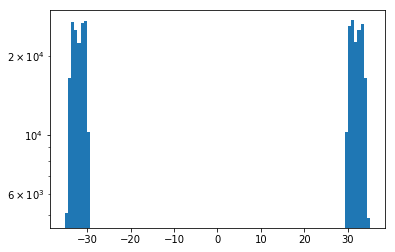

dz


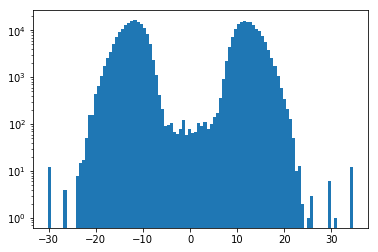

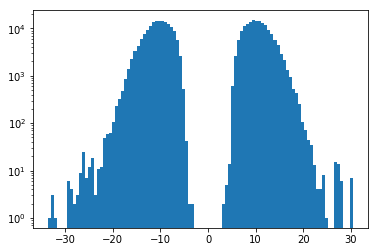

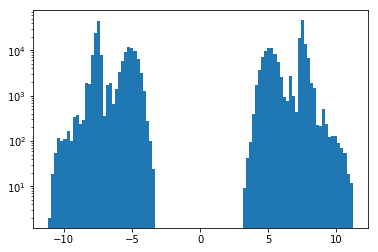

z0


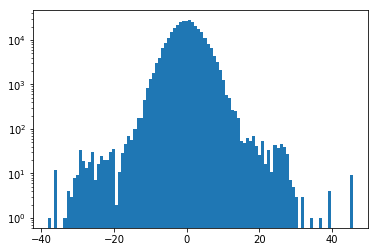

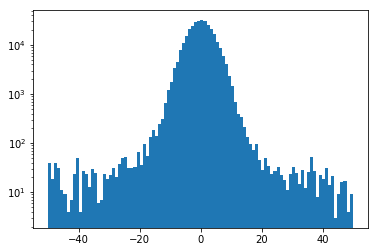

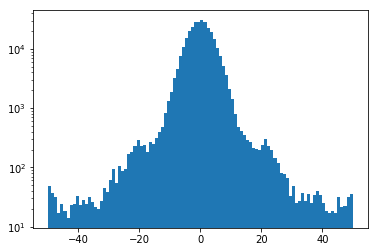

dr


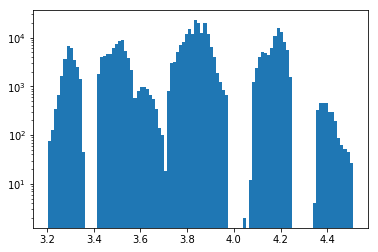

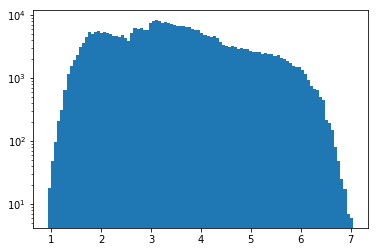

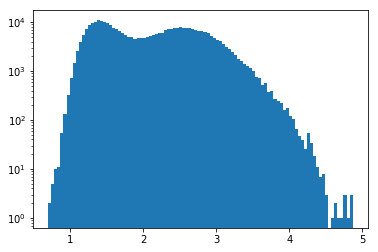

dphi zcut


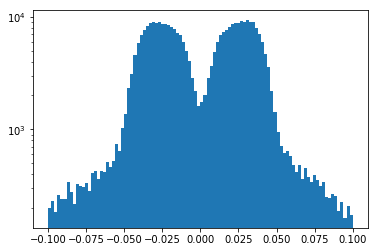

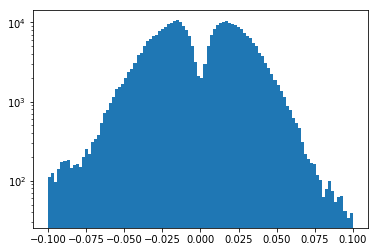

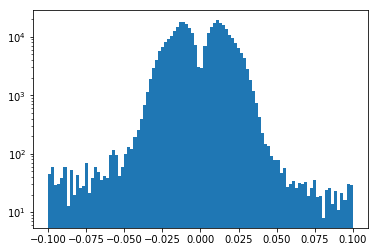

zinner zcut


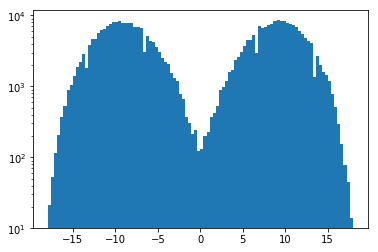

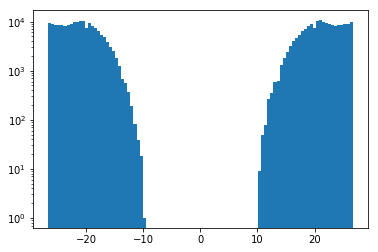

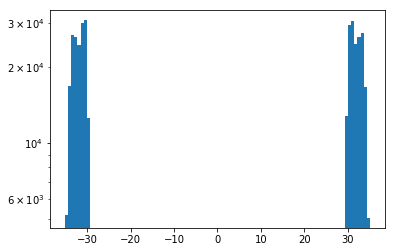

module


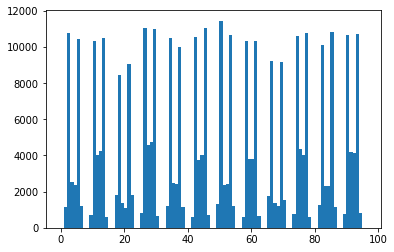

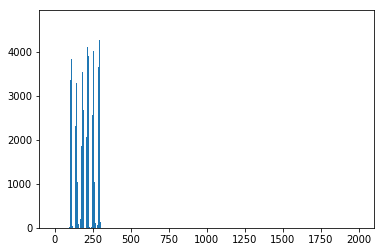

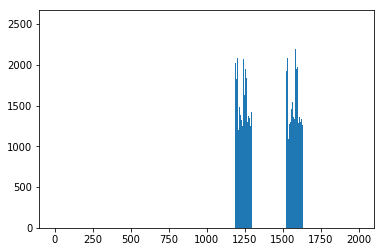

dysize


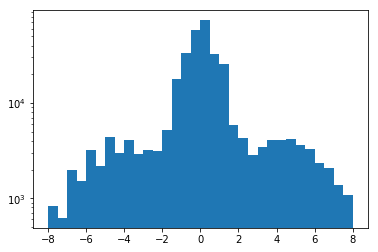

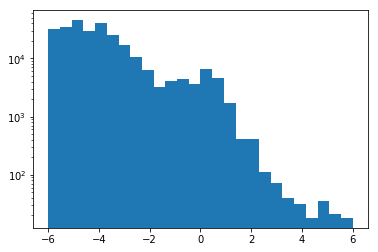

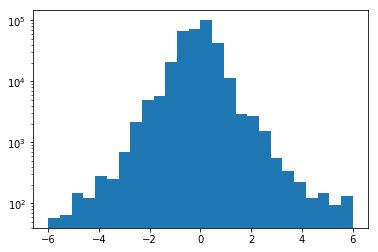

ysize


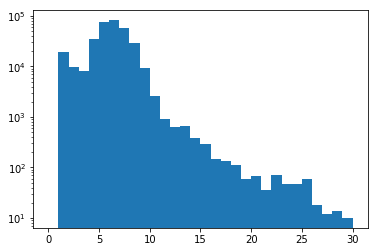

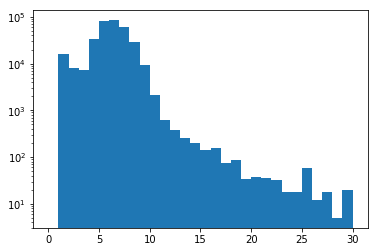

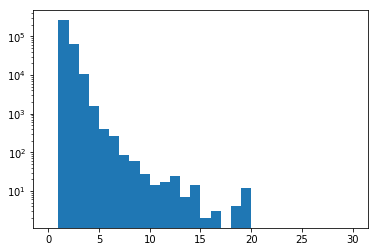

ys-pred


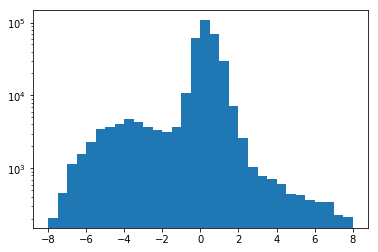

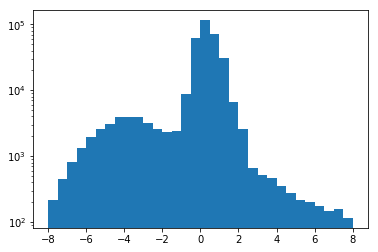

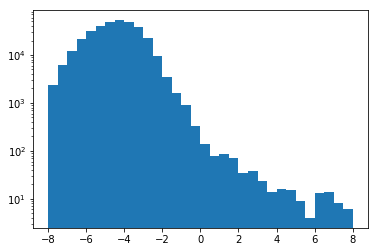

dphi


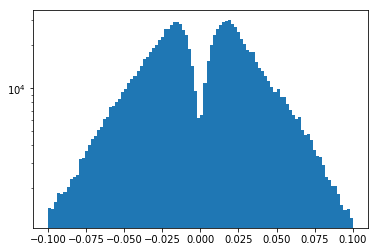

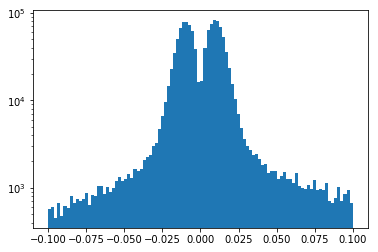

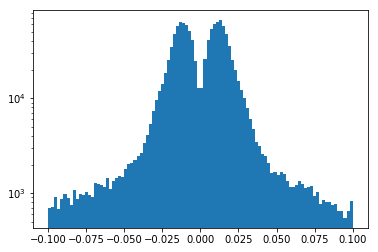

dphiNor


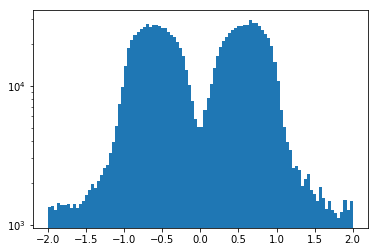

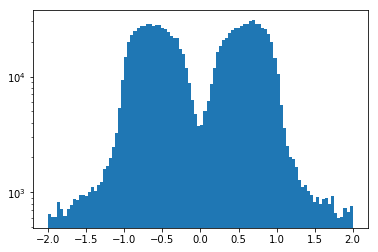

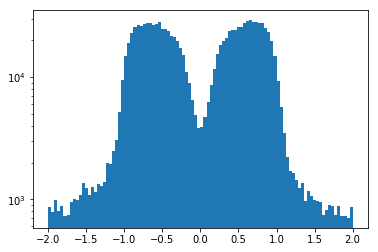

zinner


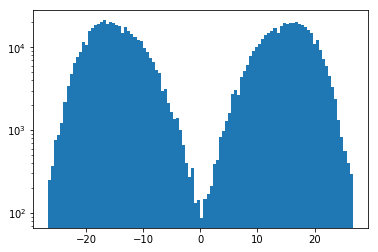

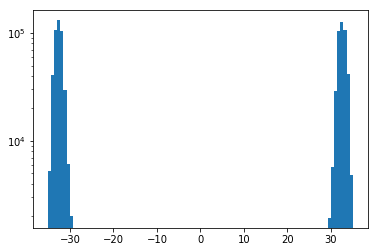

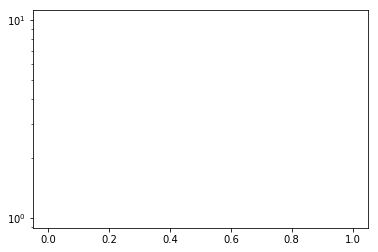

dz


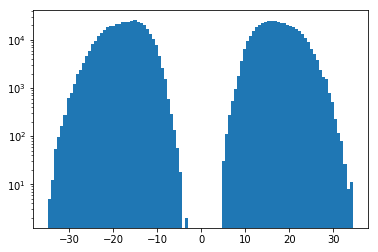

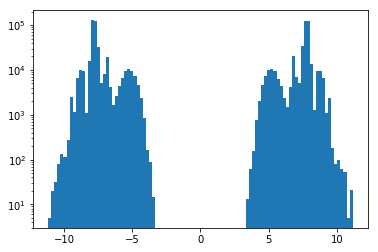

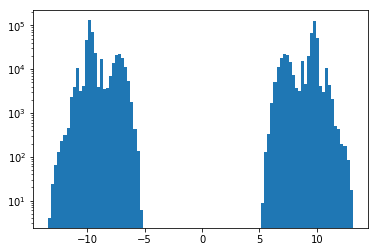

z0


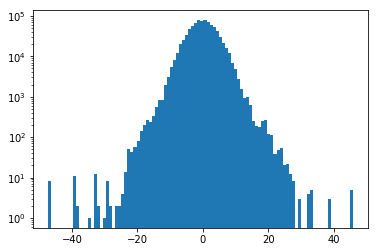

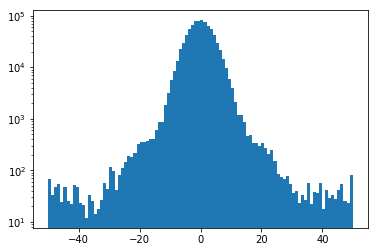

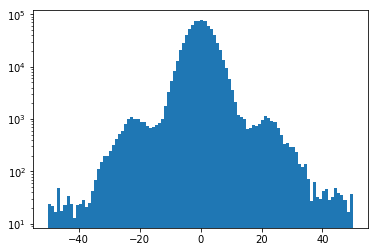

dr


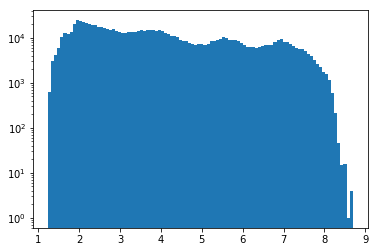

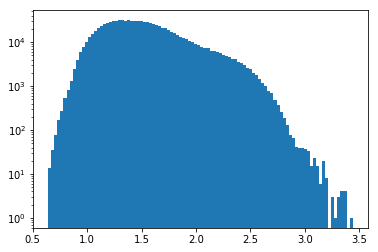

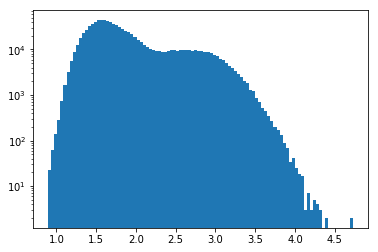

dphi zcut


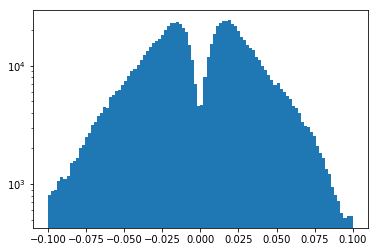

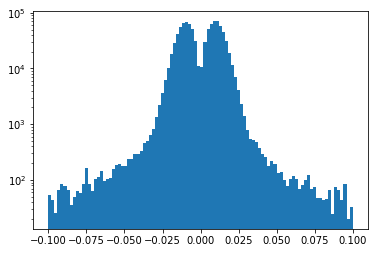

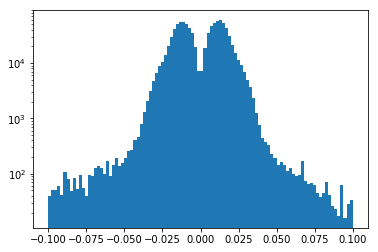

zinner zcut


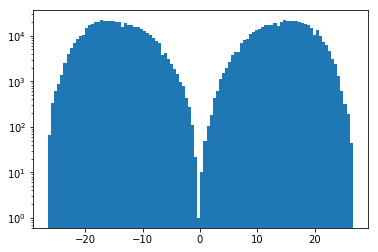

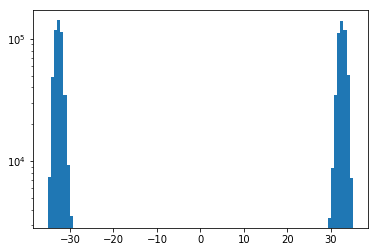

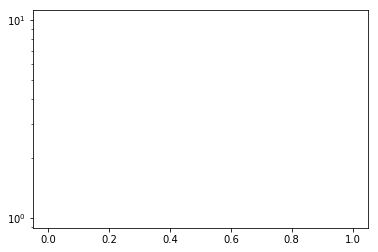

module


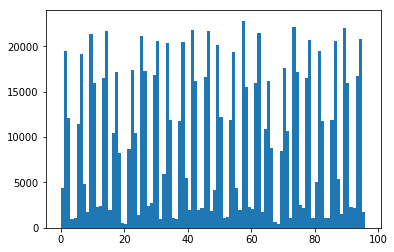

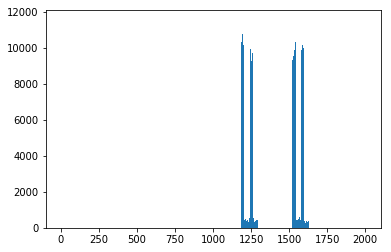

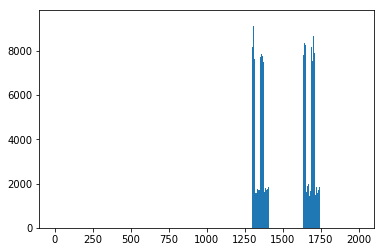

dysize


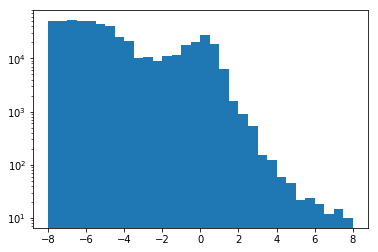

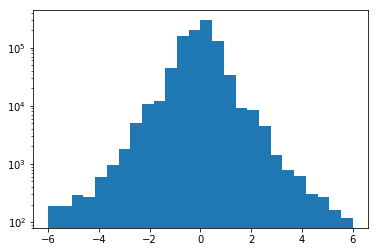

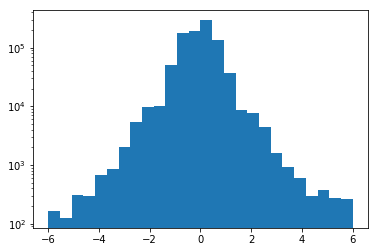

ysize


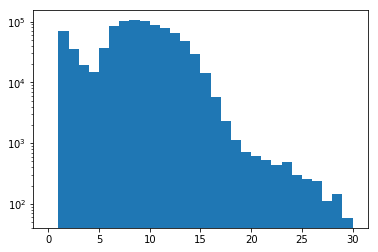

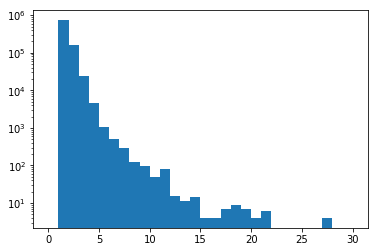

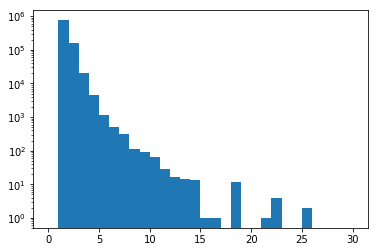

ys-pred


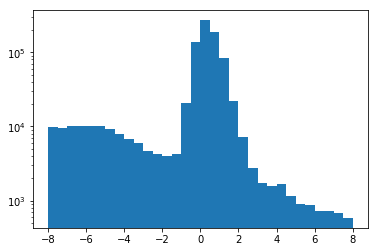

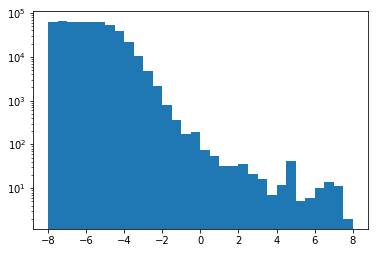

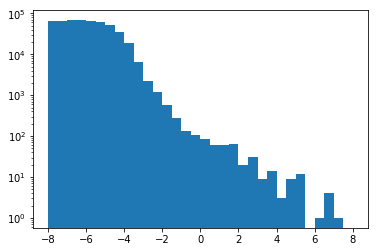

In [240]:
for quad in [t1234,t1231,t1212,t1123] :
  plotDoublets(quad,500)